The NFL Combine is the premier event for prospective college football athletes to showcase their athletic abilities to their future NFL team. This annual event attracts scouts, coaches, team owners, and team executives to Indianapolis, all in hopes of finding and evaluating the future players that will carry the future of their franchises. In addition, the NFL Combine is televised to give the general public a first-hand look into the raw athletic abilities of some of the best athletes on the planet.

Each year, the NFL's Selection Committee thoroughly examines thousands of hours of college football film to identify the players with the highest potential to be drafted, then sends out a combine invitation to those selected players. With rare exceptions, the only situations in which players decline to show up for the NFL Combine are debilitating injuries/illnesses or family emergencies.

The NFL Combine offers players the option to choose which exercises to participate in. There is a standard core set of measurable exercises, which is the main focus of this project, as well as subjective drills (ie throwing passes, interception drills, etc). The measured exercises that we will focus on are the following:

1. 40 Yard Dash - Time, in seconds, that a player covers 40 yards
2. Bench Press - The number of repetitions that a player is able to bench press 225 pounds until failure
3. Vertical Leap - The number of inches that a player is able to jump from a standing position
4. Broad Jump - The number of inches that a player jumps forward and land squarely on both feet
5. Shuttle - The time, in seconds, it takes a player to run 5 yards, then 10 yards in the opposite direction, then 5 yards back. This exercise is used to measure lateral quickness.
6. 3Cone Drill - The time, in seconds, it takes a player to make an L shape through 3 cones.

After the NFL Combine, the teams evaluate and interview the players, then come together for the NFL Draft. This consists of 7 rounds of about 32 players each (~230 players drafted) in which teams go in order and select players in each round, where the teams with the worst regular season records usually go first in selecting available players in the selection pool. The difference in contract values in each of these rounds is immense - for example, the 2017 Draft's first overall pick, was a 4 year, $30 million dollar contract, while the first pick of the 2nd Round, Kevin King, signed a 4 year, $7 million dollar contract.

The purpose of this project exercise is to find trends between performance at the NFL Combine and how highly these players are drafted. In doing so, both the teams and prospective players both have a clearer understanding of what this historical data looks like and how they stand comparatively to past performances. For players, these insights will serve to give clear benchmarks to help shape their training goals, as well as give proper perspective on how they stand relative to past performances. For NFL teams, this project will give a more in-depth, multi-dimensional, and quantitative methodology for understanding how great or poor an NFL Combine performance is.

Every major evaluator of talent (scout, General Manager, head coach, player personnel staff, etc) usually has a strong ability to make a fairly consistent heuristic analysis of what level a player is based on their Combine measurables. For example, any strength and conditioning coach at the college level could probably break down what are solid combine numbers for a player at a given position to get drafted. However, the ability for any human brain to process and compute the quantitative relationships of performance and Draft selection across many important dimensions like weight, height, and position becomes incredibly difficult at a large scale.

The data analysis and visualization from this project aims to provide in-depth, empirical analysis on the relationship between performance at the NFL Combine and performance in the NFL Draft. We will do so by grouping players by their positions, then creating violinplots (to show the range and concentration of each position group) and running regressions on the scatterplots across various exercises (to show the spread of the data and arrive at a function for the best fit line).

Three regression lines, seperated by Draft performance (Drafted in Rounds 1-3, Drafted in Rounds 4-7, Undrafted) have been run to show the relationship between various combine exercises against weight. We chose weight because it is the single most import variable that gives context and relevance to a certain exercise. For example, a 180 pound player running a 4.7 second 40-yard dash is considered an atrocious time, while it would be an absolutely amazing time for a 300 pound lineman.

So what does the data tell us?

The first, and most obvious question to answer, is whether or not there was a noticeable difference between the performances of those drafted in Rounds 1-3, 4-7, and those that went Undrafted.

The timed exercises - 40 yard dash, Shuttle, and 3Cone are exercises in which a lower time value is considered a better performance. On the contrary, bench press, vertical leap, and broad jump are considered better performances when the number is larger. 

When looking at the scatterplots and their regressions, we can confirm what seems to be the most self-obvious hypothesis, which is that players drafted earlier tend to have better combine performances. We can see this as most of the regression lines follow the predictable order of Rounds 1-3 having the best results, then Rounds 4-7, then Undrafted. In every exercise (with all position groups consolidated), every regression line strictly dominates the next.

As expected, the following exercises have a positive correlation with weight - Bench Press, 40 yard dash, Shuttle, and 3Cone. Vertical Leap and Broad Jump exhibit an expected negative correlation.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

#import datasets
combine_measurables = pd.read_csv('CombineMeasurables.csv')
rounds = pd.read_csv('NFL_Draft_Rounds.csv')

In [2]:
#Data Wrangling

#We want all columns except College
combine_measurables = combine_measurables[['Year', 'Name', 'POS', 'Height', 'Weight', 'Wonderlic', '40_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle', '3Cone']]

#We only want the following columns from rounds - Player, Year, Round, and Pos
rounds = rounds[['Player', 'Year', 'Rnd', 'Pos']]

#Rename columns to make join operation easier
combine_measurables = combine_measurables.rename(index = str, columns = {'Name': 'Player', 'POS':'Pos'})

#With this dataset, we need to eliminate all values for which Year < 1987, since NFL Combine started in 1987
rounds = rounds[rounds['Year'] >= 1987]

#Because there used to be 12 Rounds in the NFL Draft in the old days, as opposed to 7 now, we will standardize by eliminating all rows with anybody in the past drafted past the 7th round
rounds = rounds[rounds['Rnd'] <= 7]

#Eliminate Punters, "P", and Kickers, "K", from list, as their success has almost no correlation to Combine results
rounds = rounds[rounds['Pos'] != 'K']
rounds = rounds[rounds['Pos'] != 'P']
combine_measurables = combine_measurables[combine_measurables['Pos'] != 'K']
combine_measurables = combine_measurables[combine_measurables['Pos'] != 'P']

#Consolidate, using for consolidate() method, position groups to standard superset to reduce number of dimensions. For example, Defensive Backs have similar measurables and consist of Cornerbacks, Strong Safeties, and Free Safeties.
def consolidate(i):
    if i == 'CB' or i == 'FS' or i == 'SS':
        return 'DB'
    elif i == 'ILB' or i == 'OLB':
        return 'LB'
    elif i == 'NT' or i == 'DE' or i == 'DT':
        return 'DL'
    elif i == 'C' or i == 'LS' or i == 'G' or i == 'T' or i == 'OT' or i == 'OG':
        return 'OL'
    else:
        return str(i)

#Apply the consolidate() method to 'Pos' columns for both dataframes
rounds['Pos'] = rounds['Pos'].apply(consolidate)
combine_measurables['Pos'] = combine_measurables['Pos'].apply(consolidate)

In [3]:
#Left Join on the two columns to attach the 'Rnd' column to combine_measurables. We want the NaN values because this represents the group of players that went undrafted, and we will change those values later
df_joined = combine_measurables.merge(rounds, how = 'left', on = ['Year', 'Player', 'Pos'])


#We can now drop the columns 'Year' and 'Player', as they no longer serve a purpose
df_joined = df_joined[['Rnd', 'Pos', 'Height', 'Weight', 'Wonderlic', '40_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle', '3Cone']]

#We want to divide the rounds in which 
def consolidate_rounds(i):
    if i == 1 or i == 2 or i == 3:
        return '1-3'
    elif i == 4 or i == 5 or i == 6 or i == 7:
        return '4-7'
    else:
        return 'Undrafted'

#Now, Rnd will be a category (1-3, 4-7, or Undrafted) instead of an integer or NaN
df_joined['Rnd'] = df_joined['Rnd'].apply(consolidate_rounds)


In [4]:
#Create dataframes split by position groups

df_OL = df_joined[df_joined['Pos'] == 'OL']
df_DB = df_joined[df_joined['Pos'] == 'DB']
df_DL = df_joined[df_joined['Pos'] == 'DL']
df_FB = df_joined[df_joined['Pos'] == 'FB']
df_LB = df_joined[df_joined['Pos'] == 'LB']
df_QB = df_joined[df_joined['Pos'] == 'QB']
df_RB = df_joined[df_joined['Pos'] == 'RB']
df_TE = df_joined[df_joined['Pos'] == 'TE']
df_WR = df_joined[df_joined['Pos'] == 'WR']


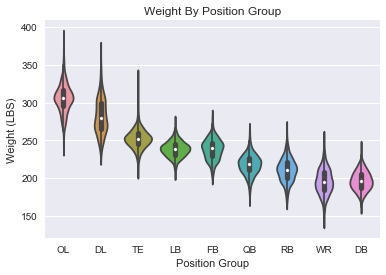

In [5]:
#Create a violinplot for weight of each position group
Weight_df_pos = df_joined[['Pos', 'Weight']].dropna()
Weight_df_pos = Weight_df_pos[Weight_df_pos['Weight'] != 163]

sns.set()
_ = sns.violinplot('Pos', 'Weight', data = Weight_df_pos, order = ['OL', 'DL', 'TE', 'LB', 'FB', 'QB', 'RB', 'WR', 'DB'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Weight (LBS)')
_ = plt.title('Weight By Position Group')
_ = plt.show()


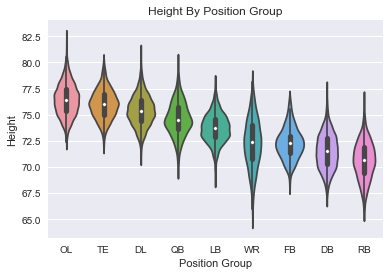

In [6]:
#Create a violinplot for height of each position group
Height_df_pos = df_joined[['Pos', 'Height']].dropna()

#remove outlier in TE (5' 5")
Height_df_pos = Height_df_pos[Height_df_pos['Height'] != 64.9]


sns.set()
_ = sns.violinplot('Pos', 'Height', data = Height_df_pos, order = ['OL', 'TE', 'DL', 'QB', 'LB', 'WR', 'FB', 'DB', 'RB'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Height')
_ = plt.title('Height By Position Group')
_ = plt.show()



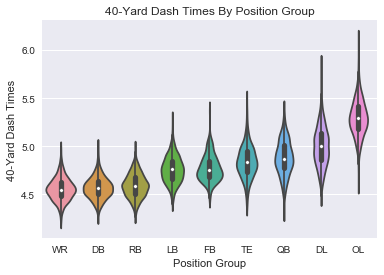

In [7]:
#Create a violinplot for 40 Yard dash times, grouped by position
forty_yard_df_pos = df_joined[['Pos', '40_Yard']].dropna()

sns.set()
_ = sns.violinplot('Pos', '40_Yard', data = forty_yard_df_pos, order = ['WR', 'DB', 'RB', 'LB', 'FB', 'TE', 'QB', 'DL', 'OL'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Times By Position Group')
_ = plt.show()

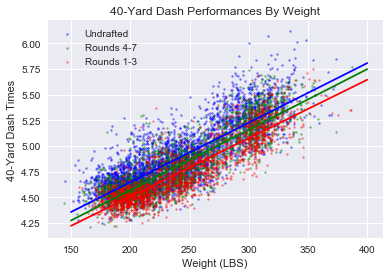

Regression for Undrafted: y=0.00580709793575x + 3.48423661243, R-Squared = 0.688453607181
Regression for Rounds 4-7: y=0.00590284696523x + 3.38716539501, R-Squared = 0.763116900873
Regression for Rounds 1-3: y=0.0056979658304x + 3.36575771469, R-Squared = 0.758969510135


In [8]:
#Create a scatterplot of 40 yard dash times against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

forty_yard_df_weight_13 = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_13 = forty_yard_df_weight_13[forty_yard_df_weight_13['Rnd'] == '1-3']

forty_yard_df_weight_47 = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_47 = forty_yard_df_weight_47[forty_yard_df_weight_47['Rnd'] == '4-7']

forty_yard_df_weight_Undrafted = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_Undrafted = forty_yard_df_weight_Undrafted[forty_yard_df_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_Undrafted, b_Undrafted = np.polyfit(forty_yard_df_weight_Undrafted['Weight'], forty_yard_df_weight_Undrafted['40_Yard'], deg=1)
m_47, b_47 = np.polyfit(forty_yard_df_weight_47['Weight'], forty_yard_df_weight_47['40_Yard'], deg=1)
m_13, b_13 = np.polyfit(forty_yard_df_weight_13['Weight'], forty_yard_df_weight_13['40_Yard'], deg=1)


#calculate R squared of each group
def rsquared(x, y):

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

forty_rsquared_Undrafted = rsquared(forty_yard_df_weight_Undrafted['Weight'], forty_yard_df_weight_Undrafted['40_Yard'])
forty_rsquared_47 = rsquared(forty_yard_df_weight_47['Weight'], forty_yard_df_weight_47['40_Yard'])
forty_rsquared_13 = rsquared(forty_yard_df_weight_13['Weight'], forty_yard_df_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_Undrafted*x + b_Undrafted, color = 'blue')
_ = plt.plot(x, m_47*x + b_47, color = 'green')
_ = plt.plot(x, m_13*x + b_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances By Weight')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_Undrafted) + 'x + ' + str(b_Undrafted) + ', R-Squared = ' + str(forty_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_47) + 'x + ' + str(b_47) + ', R-Squared = ' + str(forty_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_13) + 'x + ' + str(b_13) + ', R-Squared = ' + str(forty_rsquared_13))

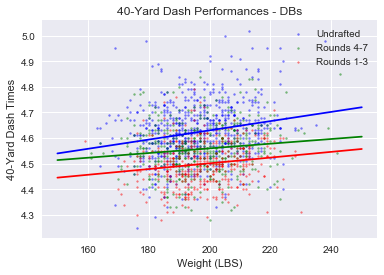

Regression for Undrafted: y=0.00180484770438x + 4.26890470981, R-Squared = 0.0432370138062
Regression for Rounds 4-7: y=0.000915727966408x + 4.37628421537, R-Squared = 0.0159635935797
Regression for Rounds 1-3: y=0.00112073307781x + 4.27683541661, R-Squared = 0.022854123052


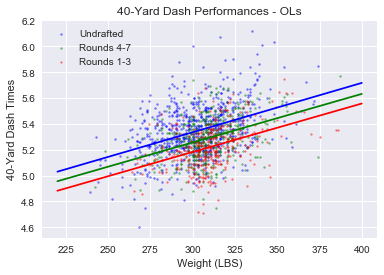

Regression for Undrafted: y=0.00381260671685x + 4.1915508961, R-Squared = 0.155123794338
Regression for Rounds 4-7: y=0.00375092684363x + 4.13124809234, R-Squared = 0.156602510563
Regression for Rounds 1-3: y=0.00374618916064x + 4.05872473067, R-Squared = 0.152680600908


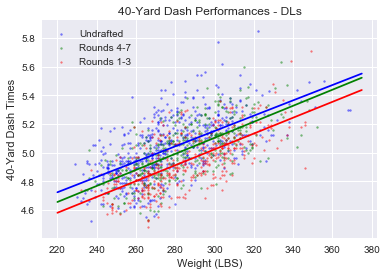

Regression for Undrafted: y=0.00534921983766x + 3.54575902903, R-Squared = 0.373481295445
Regression for Rounds 4-7: y=0.00559956848089x + 3.42285182703, R-Squared = 0.439998270068
Regression for Rounds 1-3: y=0.00553273816241x + 3.36217564204, R-Squared = 0.439680533048


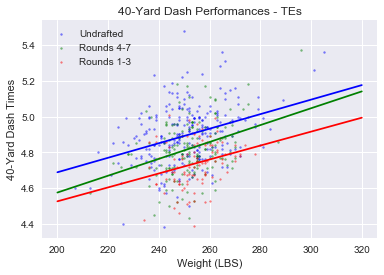

Regression for Undrafted: y=0.00406597562475x + 3.87478780641, R-Squared = 0.117232999892
Regression for Rounds 4-7: y=0.00471696239873x + 3.63120688442, R-Squared = 0.127259382708
Regression for Rounds 1-3: y=0.00390028034597x + 3.74534340181, R-Squared = 0.0699751421193


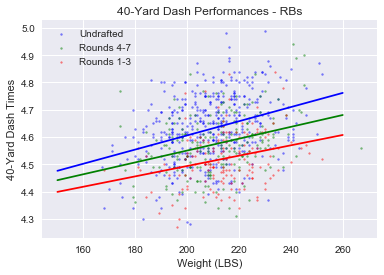

Regression for Undrafted: y=0.00259721366964x + 4.08648783528, R-Squared = 0.108831209504
Regression for Rounds 4-7: y=0.00217314065761x + 4.11569860292, R-Squared = 0.0921811391395
Regression for Rounds 1-3: y=0.00189825797453x + 4.11394480701, R-Squared = 0.0703110026497


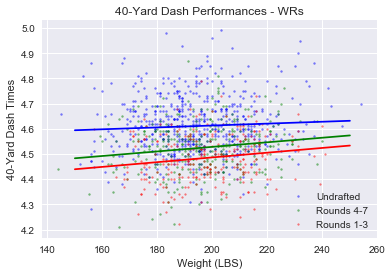

Regression for Undrafted: y=0.000375248629906x + 4.53765646229, R-Squared = 0.00348715402885
Regression for Rounds 4-7: y=0.000906128816159x + 4.34679923138, R-Squared = 0.021884712633
Regression for Rounds 1-3: y=0.000940110503097x + 4.29813891597, R-Squared = 0.0241204827702


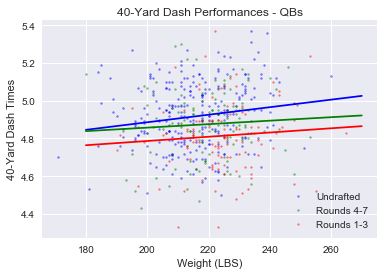

Regression for Undrafted: y=0.00200120688221x + 4.48556849262, R-Squared = 0.0248402558524
Regression for Rounds 4-7: y=0.000923092563023x + 4.6727857649, R-Squared = 0.00435881441339
Regression for Rounds 1-3: y=0.00112367759123x + 4.56181286413, R-Squared = 0.00597281121632


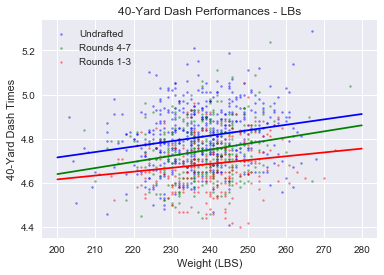

Regression for Undrafted: y=0.00245659182335x + 4.22385747918, R-Squared = 0.0415644448166
Regression for Rounds 4-7: y=0.00276068339808x + 4.08748123435, R-Squared = 0.0424402359088
Regression for Rounds 1-3: y=0.00174134077291x + 4.26742256192, R-Squared = 0.020867242118


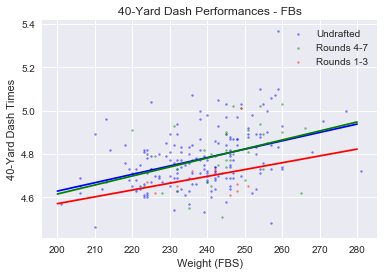

Regression for Undrafted: y=0.00387175157245x + 3.85380790014, R-Squared = 0.1630249657
Regression for Rounds 4-7: y=0.00416156552755x + 3.78238636911, R-Squared = 0.126710419088
Regression for Rounds 1-3: y=0.00315175879397x + 3.93970452261, R-Squared = 0.0721032650853


In [37]:
#Scatterplot for DB Group - 40 yard dash
forty_yard_db_weight_13 = df_DB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_db_weight_13 = forty_yard_db_weight_13[forty_yard_db_weight_13['Rnd'] == '1-3']

forty_yard_db_weight_47 = df_DB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_db_weight_47 = forty_yard_db_weight_47[forty_yard_db_weight_47['Rnd'] == '4-7']

forty_yard_db_weight_Undrafted = df_DB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_db_weight_Undrafted = forty_yard_db_weight_Undrafted[forty_yard_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(forty_yard_db_weight_Undrafted['Weight'], forty_yard_db_weight_Undrafted['40_Yard'], deg=1)
m_db_47, b_db_47 = np.polyfit(forty_yard_db_weight_47['Weight'], forty_yard_db_weight_47['40_Yard'], deg=1)
m_db_13, b_db_13 = np.polyfit(forty_yard_db_weight_13['Weight'], forty_yard_db_weight_13['40_Yard'], deg=1)

forty_db_rsquared_Undrafted = rsquared(forty_yard_db_weight_Undrafted['Weight'], forty_yard_db_weight_Undrafted['40_Yard'])
forty_db_rsquared_47 = rsquared(forty_yard_db_weight_47['Weight'], forty_yard_db_weight_47['40_Yard'])
forty_db_rsquared_13 = rsquared(forty_yard_db_weight_13['Weight'], forty_yard_db_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(forty_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(forty_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(forty_db_rsquared_13))


#Scatterplot for OL Group
forty_yard_OL_weight_13 = df_OL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_OL_weight_13 = forty_yard_OL_weight_13[forty_yard_OL_weight_13['Rnd'] == '1-3']

forty_yard_OL_weight_47 = df_OL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_OL_weight_47 = forty_yard_OL_weight_47[forty_yard_OL_weight_47['Rnd'] == '4-7']

forty_yard_OL_weight_Undrafted = df_OL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_OL_weight_Undrafted = forty_yard_OL_weight_Undrafted[forty_yard_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(forty_yard_OL_weight_Undrafted['Weight'], forty_yard_OL_weight_Undrafted['40_Yard'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(forty_yard_OL_weight_47['Weight'], forty_yard_OL_weight_47['40_Yard'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(forty_yard_OL_weight_13['Weight'], forty_yard_OL_weight_13['40_Yard'], deg=1)

forty_OL_rsquared_Undrafted = rsquared(forty_yard_OL_weight_Undrafted['Weight'], forty_yard_OL_weight_Undrafted['40_Yard'])
forty_OL_rsquared_47 = rsquared(forty_yard_OL_weight_47['Weight'], forty_yard_OL_weight_47['40_Yard'])
forty_OL_rsquared_13 = rsquared(forty_yard_OL_weight_13['Weight'], forty_yard_OL_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(forty_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(forty_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(forty_OL_rsquared_13))


#scatterplot for 40 yard dash for DL Group
forty_yard_DL_weight_13 = df_DL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_DL_weight_13 = forty_yard_DL_weight_13[forty_yard_DL_weight_13['Rnd'] == '1-3']

forty_yard_DL_weight_47 = df_DL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_DL_weight_47 = forty_yard_DL_weight_47[forty_yard_DL_weight_47['Rnd'] == '4-7']

forty_yard_DL_weight_Undrafted = df_DL[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_DL_weight_Undrafted = forty_yard_DL_weight_Undrafted[forty_yard_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(forty_yard_DL_weight_Undrafted['Weight'], forty_yard_DL_weight_Undrafted['40_Yard'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(forty_yard_DL_weight_47['Weight'], forty_yard_DL_weight_47['40_Yard'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(forty_yard_DL_weight_13['Weight'], forty_yard_DL_weight_13['40_Yard'], deg=1)

forty_DL_rsquared_Undrafted = rsquared(forty_yard_DL_weight_Undrafted['Weight'], forty_yard_DL_weight_Undrafted['40_Yard'])
forty_DL_rsquared_47 = rsquared(forty_yard_DL_weight_47['Weight'], forty_yard_DL_weight_47['40_Yard'])
forty_DL_rsquared_13 = rsquared(forty_yard_DL_weight_13['Weight'], forty_yard_DL_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(forty_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(forty_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(forty_DL_rsquared_13))

#scatterplot for 40 yard dash for TE Group
forty_yard_TE_weight_13 = df_TE[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_TE_weight_13 = forty_yard_TE_weight_13[forty_yard_TE_weight_13['Rnd'] == '1-3']

forty_yard_TE_weight_47 = df_TE[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_TE_weight_47 = forty_yard_TE_weight_47[forty_yard_TE_weight_47['Rnd'] == '4-7']

forty_yard_TE_weight_Undrafted = df_TE[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_TE_weight_Undrafted = forty_yard_TE_weight_Undrafted[forty_yard_TE_weight_Undrafted['Rnd'] == 'Undrafted']
forty_yard_TE_weight_Undrafted = forty_yard_TE_weight_Undrafted[forty_yard_TE_weight_Undrafted['Weight'] > 180]
forty_yard_TE_weight_Undrafted = forty_yard_TE_weight_Undrafted[forty_yard_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([200,320])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (forty_yard_TE_weight_Undrafted['Weight'], forty_yard_TE_weight_Undrafted['40_Yard'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(forty_yard_TE_weight_47['Weight'], forty_yard_TE_weight_47['40_Yard'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (forty_yard_TE_weight_13['Weight'], forty_yard_TE_weight_13['40_Yard'], deg=1)

forty_TE_rsquared_Undrafted = rsquared(forty_yard_TE_weight_Undrafted['Weight'], forty_yard_TE_weight_Undrafted['40_Yard'])
forty_TE_rsquared_47 = rsquared(forty_yard_TE_weight_47['Weight'], forty_yard_TE_weight_47['40_Yard'])
forty_TE_rsquared_13 = rsquared(forty_yard_TE_weight_13['Weight'], forty_yard_TE_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(forty_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(forty_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(forty_TE_rsquared_13))


#scatterplot for 40 yard dash for RB Group
forty_yard_RB_weight_13 = df_RB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_RB_weight_13 = forty_yard_RB_weight_13[forty_yard_RB_weight_13['Rnd'] == '1-3']

forty_yard_RB_weight_47 = df_RB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_RB_weight_47 = forty_yard_RB_weight_47[forty_yard_RB_weight_47['Rnd'] == '4-7']

forty_yard_RB_weight_Undrafted = df_RB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_RB_weight_Undrafted = forty_yard_RB_weight_Undrafted[forty_yard_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,260])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (forty_yard_RB_weight_Undrafted ['Weight'], forty_yard_RB_weight_Undrafted ['40_Yard'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(forty_yard_RB_weight_47['Weight'], forty_yard_RB_weight_47['40_Yard'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (forty_yard_RB_weight_13['Weight'], forty_yard_RB_weight_13['40_Yard'], deg=1)

forty_RB_rsquared_Undrafted = rsquared(forty_yard_RB_weight_Undrafted['Weight'], forty_yard_RB_weight_Undrafted['40_Yard'])
forty_RB_rsquared_47 = rsquared(forty_yard_RB_weight_47['Weight'], forty_yard_RB_weight_47['40_Yard'])
forty_RB_rsquared_13 = rsquared(forty_yard_RB_weight_13['Weight'], forty_yard_RB_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(forty_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(forty_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(forty_RB_rsquared_13))


#scatterplot for 40 yard dash for WR Group
forty_yard_WR_weight_13 = df_WR[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_WR_weight_13 = forty_yard_WR_weight_13[forty_yard_WR_weight_13['Rnd'] == '1-3']

forty_yard_WR_weight_47 = df_WR[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_WR_weight_47 = forty_yard_WR_weight_47[forty_yard_WR_weight_47['Rnd'] == '4-7']

forty_yard_WR_weight_Undrafted = df_WR[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_WR_weight_Undrafted = forty_yard_WR_weight_Undrafted[forty_yard_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (forty_yard_WR_weight_Undrafted ['Weight'], forty_yard_WR_weight_Undrafted ['40_Yard'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(forty_yard_WR_weight_47['Weight'], forty_yard_WR_weight_47['40_Yard'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (forty_yard_WR_weight_13['Weight'], forty_yard_WR_weight_13['40_Yard'], deg=1)

forty_WR_rsquared_Undrafted = rsquared(forty_yard_WR_weight_Undrafted['Weight'], forty_yard_WR_weight_Undrafted['40_Yard'])
forty_WR_rsquared_47 = rsquared(forty_yard_WR_weight_47['Weight'], forty_yard_WR_weight_47['40_Yard'])
forty_WR_rsquared_13 = rsquared(forty_yard_WR_weight_13['Weight'], forty_yard_WR_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(forty_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(forty_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(forty_WR_rsquared_13))


#scatterplot for 40 yard dash for QB Group
forty_yard_QB_weight_13 = df_QB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_QB_weight_13 = forty_yard_QB_weight_13[forty_yard_QB_weight_13['Rnd'] == '1-3']

forty_yard_QB_weight_47 = df_QB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_QB_weight_47 = forty_yard_QB_weight_47[forty_yard_QB_weight_47['Rnd'] == '4-7']

forty_yard_QB_weight_Undrafted = df_QB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_QB_weight_Undrafted = forty_yard_QB_weight_Undrafted[forty_yard_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (forty_yard_QB_weight_Undrafted ['Weight'], forty_yard_QB_weight_Undrafted ['40_Yard'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(forty_yard_QB_weight_47['Weight'], forty_yard_QB_weight_47['40_Yard'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (forty_yard_QB_weight_13['Weight'], forty_yard_QB_weight_13['40_Yard'], deg=1)

forty_QB_rsquared_Undrafted = rsquared(forty_yard_QB_weight_Undrafted['Weight'], forty_yard_QB_weight_Undrafted['40_Yard'])
forty_QB_rsquared_47 = rsquared(forty_yard_QB_weight_47['Weight'], forty_yard_QB_weight_47['40_Yard'])
forty_QB_rsquared_13 = rsquared(forty_yard_QB_weight_13['Weight'], forty_yard_QB_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(forty_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(forty_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(forty_QB_rsquared_13))

#scatterplot for 40 yard dash for LB Group
forty_yard_LB_weight_13 = df_LB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_LB_weight_13 = forty_yard_LB_weight_13[forty_yard_LB_weight_13['Rnd'] == '1-3']

forty_yard_LB_weight_47 = df_LB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_LB_weight_47 = forty_yard_LB_weight_47[forty_yard_LB_weight_47['Rnd'] == '4-7']

forty_yard_LB_weight_Undrafted = df_LB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_LB_weight_Undrafted = forty_yard_LB_weight_Undrafted[forty_yard_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (forty_yard_LB_weight_Undrafted ['Weight'], forty_yard_LB_weight_Undrafted ['40_Yard'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(forty_yard_LB_weight_47['Weight'], forty_yard_LB_weight_47['40_Yard'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (forty_yard_LB_weight_13['Weight'], forty_yard_LB_weight_13['40_Yard'], deg=1)

forty_LB_rsquared_Undrafted = rsquared(forty_yard_LB_weight_Undrafted['Weight'], forty_yard_LB_weight_Undrafted['40_Yard'])
forty_LB_rsquared_47 = rsquared(forty_yard_LB_weight_47['Weight'], forty_yard_LB_weight_47['40_Yard'])
forty_LB_rsquared_13 = rsquared(forty_yard_LB_weight_13['Weight'], forty_yard_LB_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(forty_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(forty_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(forty_LB_rsquared_13))

#scatterplot for 40 yard dash for FB Group
forty_yard_FB_weight_13 = df_FB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_FB_weight_13 = forty_yard_FB_weight_13[forty_yard_FB_weight_13['Rnd'] == '1-3']

forty_yard_FB_weight_47 = df_FB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_FB_weight_47 = forty_yard_FB_weight_47[forty_yard_FB_weight_47['Rnd'] == '4-7']

forty_yard_FB_weight_Undrafted = df_FB[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_FB_weight_Undrafted = forty_yard_FB_weight_Undrafted[forty_yard_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (forty_yard_FB_weight_Undrafted ['Weight'], forty_yard_FB_weight_Undrafted ['40_Yard'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(forty_yard_FB_weight_47['Weight'], forty_yard_FB_weight_47['40_Yard'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (forty_yard_FB_weight_13['Weight'], forty_yard_FB_weight_13['40_Yard'], deg=1)

forty_FB_rsquared_Undrafted = rsquared(forty_yard_FB_weight_Undrafted['Weight'], forty_yard_FB_weight_Undrafted['40_Yard'])
forty_FB_rsquared_47 = rsquared(forty_yard_FB_weight_47['Weight'], forty_yard_FB_weight_47['40_Yard'])
forty_FB_rsquared_13 = rsquared(forty_yard_FB_weight_13['Weight'], forty_yard_FB_weight_13['40_Yard'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatFBrplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (FBS)')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(forty_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(forty_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(forty_FB_rsquared_13))


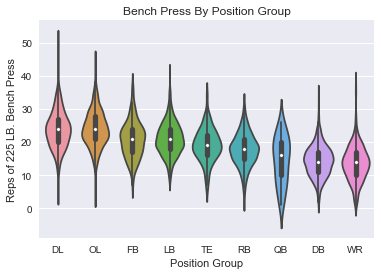

In [38]:
#Create a violinplot for bench press (number of reps at 225 lbs), grouped by position
bench_press_df_pos = df_joined[['Pos', 'Bench_Press']].dropna()

sns.set()
_ = sns.violinplot('Pos', 'Bench_Press', data = bench_press_df_pos, order = ['DL', 'OL', 'FB', 'LB', 'TE', 'RB', 'QB', 'DB', 'WR'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Reps of 225 LB. Bench Press')
_ = plt.title('Bench Press By Position Group')
_ = plt.show()


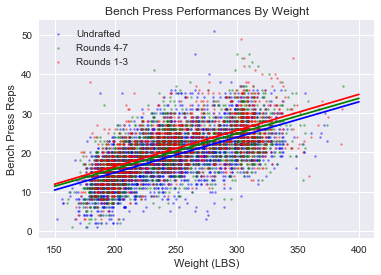

Regression for Undrafted: y=0.0899360549844x + -3.10493388251, R-Squared = 0.368435401251
Regression for Rounds 4-7: y=0.0895764305704x + -2.07433536099, R-Squared = 0.392296803165
Regression for Rounds 1-3: y=0.0915735835247x + -1.85734939372, R-Squared = 0.427482067251


In [48]:
#Create a scatterplot of bench press reps against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

bench_press_df_weight_13 = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_df_weight_13 = bench_press_df_weight_13[bench_press_df_weight_13['Rnd'] == '1-3']

bench_press_df_weight_47 = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_df_weight_47 = bench_press_df_weight_47[bench_press_df_weight_47['Rnd'] == '4-7']

bench_press_df_weight_Undrafted = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_df_weight_Undrafted = bench_press_df_weight_Undrafted[bench_press_df_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_Undrafted, b_Undrafted = np.polyfit(bench_press_df_weight_Undrafted['Weight'], bench_press_df_weight_Undrafted['Bench_Press'], deg=1)
m_47, b_47 = np.polyfit(bench_press_df_weight_47['Weight'], bench_press_df_weight_47['Bench_Press'], deg=1)
m_13, b_13 = np.polyfit(bench_press_df_weight_13['Weight'], bench_press_df_weight_13['Bench_Press'], deg=1)


#calculate R squared of each group
def rsquared(x, y):

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

bench_press_rsquared_Undrafted = rsquared(bench_press_df_weight_Undrafted['Weight'], bench_press_df_weight_Undrafted['Bench_Press'])
bench_press_rsquared_47 = rsquared(bench_press_df_weight_47['Weight'], bench_press_df_weight_47['Bench_Press'])
bench_press_rsquared_13 = rsquared(bench_press_df_weight_13['Weight'], bench_press_df_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_Undrafted*x + b_Undrafted, color = 'blue')
_ = plt.plot(x, m_47*x + b_47, color = 'green')
_ = plt.plot(x, m_13*x + b_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = bench_press_df_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = bench_press_df_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = bench_press_df_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press Performances By Weight')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_Undrafted) + 'x + ' + str(b_Undrafted) + ', R-Squared = ' + str(bench_press_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_47) + 'x + ' + str(b_47) + ', R-Squared = ' + str(bench_press_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_13) + 'x + ' + str(b_13) + ', R-Squared = ' + str(bench_press_rsquared_13))

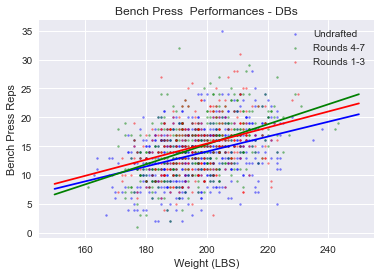

Regression for Undrafted: y=0.129339197986x + -11.8096402201, R-Squared = 0.136524076464
Regression for Rounds 4-7: y=0.173743382803x + -19.442187587, R-Squared = 0.22132812764
Regression for Rounds 1-3: y=0.139464290253x + -12.4652228626, R-Squared = 0.120059211393


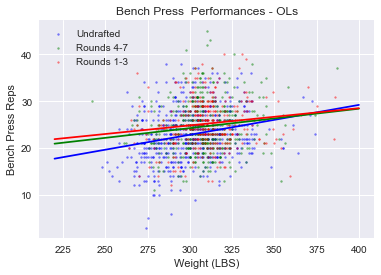

Regression for Undrafted: y=0.0638191749034x + 3.68601403915, R-Squared = 0.0576505482914
Regression for Rounds 4-7: y=0.0415209476902x + 11.7935499853, R-Squared = 0.0175079582774
Regression for Rounds 1-3: y=0.036767238056x + 13.8056945931, R-Squared = 0.018076238169


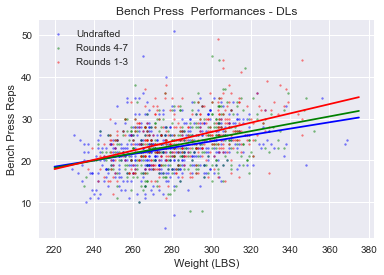

Regression for Undrafted: y=0.0756465650812x + 1.87928601251, R-Squared = 0.102194235135
Regression for Rounds 4-7: y=0.0877089064366x + -1.06735788902, R-Squared = 0.117487336389
Regression for Rounds 1-3: y=0.110763416244x + -6.42654100787, R-Squared = 0.188310924631


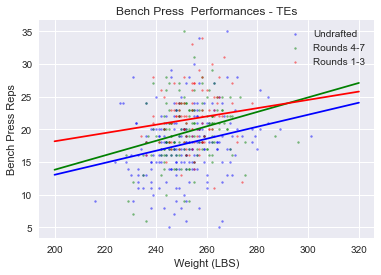

Regression for Undrafted: y=0.0918593107361x + -5.32750455473, R-Squared = 0.0548511704598
Regression for Rounds 4-7: y=0.110624223886x + -8.31289286905, R-Squared = 0.0661989288332
Regression for Rounds 1-3: y=0.0633476379029x + 5.49535690259, R-Squared = 0.0152346381746


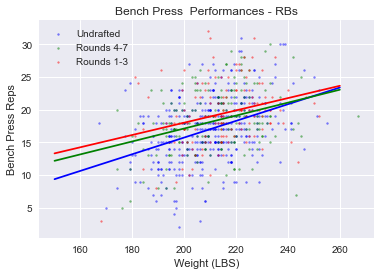

Regression for Undrafted: y=0.127270013692x + -9.71975751109, R-Squared = 0.149031659872
Regression for Rounds 4-7: y=0.0987690678667x + -2.63902915191, R-Squared = 0.10553958723
Regression for Rounds 1-3: y=0.0938769477283x + -0.770541113294, R-Squared = 0.0816744352319


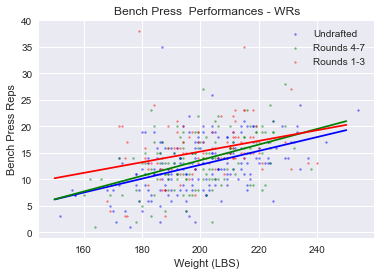

Regression for Undrafted: y=0.130920321942x + -13.4431317136, R-Squared = 0.206878635909
Regression for Rounds 4-7: y=0.147614246971x + -15.9173396017, R-Squared = 0.207599390921
Regression for Rounds 1-3: y=0.100737068325x + -4.90553268957, R-Squared = 0.083320551303


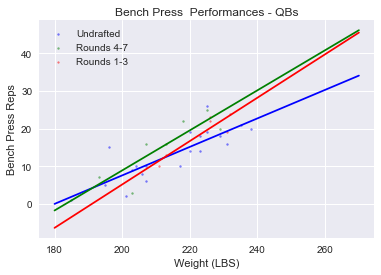

Regression for Undrafted: y=0.378698948398x + -68.1809244314, R-Squared = 0.677975977333
Regression for Rounds 4-7: y=0.532152426317x + -97.5489729086, R-Squared = 0.71199286081
Regression for Rounds 1-3: y=0.576403113478x + -110.133961491, R-Squared = 0.816716194022


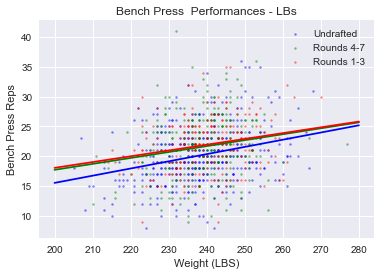

Regression for Undrafted: y=0.120832281685x + -8.66644642487, R-Squared = 0.0786691814848
Regression for Rounds 4-7: y=0.0996430409502x + -2.23559685918, R-Squared = 0.0306134052986
Regression for Rounds 1-3: y=0.0971729430749x + -1.40857692083, R-Squared = 0.0445568829401


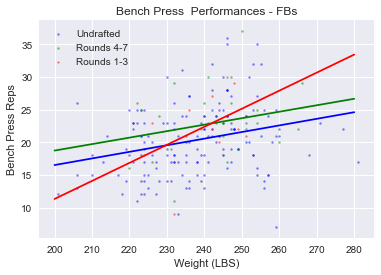

Regression for Undrafted: y=0.101082912411x + -3.71150771204, R-Squared = 0.0723916503372
Regression for Rounds 4-7: y=0.0990759293041x + -1.09460510183, R-Squared = 0.0548618675889
Regression for Rounds 1-3: y=0.276223776224x + -43.9300699301, R-Squared = 0.194520633337


In [76]:
#Scatterplot for DB Group - Bench_Press
Bench_Press_db_weight_13 = df_DB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_db_weight_13 = Bench_Press_db_weight_13[Bench_Press_db_weight_13['Rnd'] == '1-3']

Bench_Press_db_weight_47 = df_DB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_db_weight_47 = Bench_Press_db_weight_47[Bench_Press_db_weight_47['Rnd'] == '4-7']

Bench_Press_db_weight_Undrafted = df_DB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_db_weight_Undrafted = Bench_Press_db_weight_Undrafted[Bench_Press_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(Bench_Press_db_weight_Undrafted['Weight'], Bench_Press_db_weight_Undrafted['Bench_Press'], deg=1)
m_db_47, b_db_47 = np.polyfit(Bench_Press_db_weight_47['Weight'], Bench_Press_db_weight_47['Bench_Press'], deg=1)
m_db_13, b_db_13 = np.polyfit(Bench_Press_db_weight_13['Weight'], Bench_Press_db_weight_13['Bench_Press'], deg=1)

Bench_Press_db_rsquared_Undrafted = rsquared(Bench_Press_db_weight_Undrafted['Weight'], Bench_Press_db_weight_Undrafted['Bench_Press'])
Bench_Press_db_rsquared_47 = rsquared(Bench_Press_db_weight_47['Weight'], Bench_Press_db_weight_47['Bench_Press'])
Bench_Press_db_rsquared_13 = rsquared(Bench_Press_db_weight_13['Weight'], Bench_Press_db_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(Bench_Press_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(Bench_Press_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(Bench_Press_db_rsquared_13))


#Scatterplot for OL Group
Bench_Press_OL_weight_13 = df_OL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_OL_weight_13 = Bench_Press_OL_weight_13[Bench_Press_OL_weight_13['Rnd'] == '1-3']

Bench_Press_OL_weight_47 = df_OL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_OL_weight_47 = Bench_Press_OL_weight_47[Bench_Press_OL_weight_47['Rnd'] == '4-7']

Bench_Press_OL_weight_Undrafted = df_OL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_OL_weight_Undrafted = Bench_Press_OL_weight_Undrafted[Bench_Press_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(Bench_Press_OL_weight_Undrafted['Weight'], Bench_Press_OL_weight_Undrafted['Bench_Press'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(Bench_Press_OL_weight_47['Weight'], Bench_Press_OL_weight_47['Bench_Press'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(Bench_Press_OL_weight_13['Weight'], Bench_Press_OL_weight_13['Bench_Press'], deg=1)

Bench_Press_OL_rsquared_Undrafted = rsquared(Bench_Press_OL_weight_Undrafted['Weight'], Bench_Press_OL_weight_Undrafted['Bench_Press'])
Bench_Press_OL_rsquared_47 = rsquared(Bench_Press_OL_weight_47['Weight'], Bench_Press_OL_weight_47['Bench_Press'])
Bench_Press_OL_rsquared_13 = rsquared(Bench_Press_OL_weight_13['Weight'], Bench_Press_OL_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(Bench_Press_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(Bench_Press_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(Bench_Press_OL_rsquared_13))


#scatterplot for Bench_Press for DL Group
Bench_Press_DL_weight_13 = df_DL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_DL_weight_13 = Bench_Press_DL_weight_13[Bench_Press_DL_weight_13['Rnd'] == '1-3']

Bench_Press_DL_weight_47 = df_DL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_DL_weight_47 = Bench_Press_DL_weight_47[Bench_Press_DL_weight_47['Rnd'] == '4-7']

Bench_Press_DL_weight_Undrafted = df_DL[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_DL_weight_Undrafted = Bench_Press_DL_weight_Undrafted[Bench_Press_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(Bench_Press_DL_weight_Undrafted['Weight'], Bench_Press_DL_weight_Undrafted['Bench_Press'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(Bench_Press_DL_weight_47['Weight'], Bench_Press_DL_weight_47['Bench_Press'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(Bench_Press_DL_weight_13['Weight'], Bench_Press_DL_weight_13['Bench_Press'], deg=1)

Bench_Press_DL_rsquared_Undrafted = rsquared(Bench_Press_DL_weight_Undrafted['Weight'], Bench_Press_DL_weight_Undrafted['Bench_Press'])
Bench_Press_DL_rsquared_47 = rsquared(Bench_Press_DL_weight_47['Weight'], Bench_Press_DL_weight_47['Bench_Press'])
Bench_Press_DL_rsquared_13 = rsquared(Bench_Press_DL_weight_13['Weight'], Bench_Press_DL_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(Bench_Press_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(Bench_Press_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(Bench_Press_DL_rsquared_13))

#scatterplot for Bench_Press for TE Group
Bench_Press_TE_weight_13 = df_TE[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_TE_weight_13 = Bench_Press_TE_weight_13[Bench_Press_TE_weight_13['Rnd'] == '1-3']

Bench_Press_TE_weight_47 = df_TE[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_TE_weight_47 = Bench_Press_TE_weight_47[Bench_Press_TE_weight_47['Rnd'] == '4-7']

Bench_Press_TE_weight_Undrafted = df_TE[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_TE_weight_Undrafted = Bench_Press_TE_weight_Undrafted[Bench_Press_TE_weight_Undrafted['Rnd'] == 'Undrafted']
Bench_Press_TE_weight_Undrafted = Bench_Press_TE_weight_Undrafted[Bench_Press_TE_weight_Undrafted['Weight'] > 180]
Bench_Press_TE_weight_Undrafted = Bench_Press_TE_weight_Undrafted[Bench_Press_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([200,320])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (Bench_Press_TE_weight_Undrafted['Weight'], Bench_Press_TE_weight_Undrafted['Bench_Press'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(Bench_Press_TE_weight_47['Weight'], Bench_Press_TE_weight_47['Bench_Press'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (Bench_Press_TE_weight_13['Weight'], Bench_Press_TE_weight_13['Bench_Press'], deg=1)

Bench_Press_TE_rsquared_Undrafted = rsquared(Bench_Press_TE_weight_Undrafted['Weight'], Bench_Press_TE_weight_Undrafted['Bench_Press'])
Bench_Press_TE_rsquared_47 = rsquared(Bench_Press_TE_weight_47['Weight'], Bench_Press_TE_weight_47['Bench_Press'])
Bench_Press_TE_rsquared_13 = rsquared(Bench_Press_TE_weight_13['Weight'], Bench_Press_TE_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(Bench_Press_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(Bench_Press_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(Bench_Press_TE_rsquared_13))


#scatterplot for Bench_Press for RB Group
Bench_Press_RB_weight_13 = df_RB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_RB_weight_13 = Bench_Press_RB_weight_13[Bench_Press_RB_weight_13['Rnd'] == '1-3']

Bench_Press_RB_weight_47 = df_RB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_RB_weight_47 = Bench_Press_RB_weight_47[Bench_Press_RB_weight_47['Rnd'] == '4-7']

Bench_Press_RB_weight_Undrafted = df_RB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_RB_weight_Undrafted = Bench_Press_RB_weight_Undrafted[Bench_Press_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,260])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (Bench_Press_RB_weight_Undrafted ['Weight'], Bench_Press_RB_weight_Undrafted ['Bench_Press'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(Bench_Press_RB_weight_47['Weight'], Bench_Press_RB_weight_47['Bench_Press'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (Bench_Press_RB_weight_13['Weight'], Bench_Press_RB_weight_13['Bench_Press'], deg=1)

Bench_Press_RB_rsquared_Undrafted = rsquared(Bench_Press_RB_weight_Undrafted['Weight'], Bench_Press_RB_weight_Undrafted['Bench_Press'])
Bench_Press_RB_rsquared_47 = rsquared(Bench_Press_RB_weight_47['Weight'], Bench_Press_RB_weight_47['Bench_Press'])
Bench_Press_RB_rsquared_13 = rsquared(Bench_Press_RB_weight_13['Weight'], Bench_Press_RB_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(Bench_Press_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(Bench_Press_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(Bench_Press_RB_rsquared_13))


#scatterplot for Bench_Press for WR Group
Bench_Press_WR_weight_13 = df_WR[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_WR_weight_13 = Bench_Press_WR_weight_13[Bench_Press_WR_weight_13['Rnd'] == '1-3']

Bench_Press_WR_weight_47 = df_WR[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_WR_weight_47 = Bench_Press_WR_weight_47[Bench_Press_WR_weight_47['Rnd'] == '4-7']

Bench_Press_WR_weight_Undrafted = df_WR[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_WR_weight_Undrafted = Bench_Press_WR_weight_Undrafted[Bench_Press_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (Bench_Press_WR_weight_Undrafted ['Weight'], Bench_Press_WR_weight_Undrafted ['Bench_Press'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(Bench_Press_WR_weight_47['Weight'], Bench_Press_WR_weight_47['Bench_Press'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (Bench_Press_WR_weight_13['Weight'], Bench_Press_WR_weight_13['Bench_Press'], deg=1)

Bench_Press_WR_rsquared_Undrafted = rsquared(Bench_Press_WR_weight_Undrafted['Weight'], Bench_Press_WR_weight_Undrafted['Bench_Press'])
Bench_Press_WR_rsquared_47 = rsquared(Bench_Press_WR_weight_47['Weight'], Bench_Press_WR_weight_47['Bench_Press'])
Bench_Press_WR_rsquared_13 = rsquared(Bench_Press_WR_weight_13['Weight'], Bench_Press_WR_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(Bench_Press_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(Bench_Press_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(Bench_Press_WR_rsquared_13))


#scatterplot for Bench_Press for QB Group
Bench_Press_QB_weight_13 = df_QB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_QB_weight_13 = Bench_Press_QB_weight_13[Bench_Press_QB_weight_13['Rnd'] == '1-3']

Bench_Press_QB_weight_47 = df_QB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_QB_weight_47 = Bench_Press_QB_weight_47[Bench_Press_QB_weight_47['Rnd'] == '4-7']

Bench_Press_QB_weight_Undrafted = df_QB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_QB_weight_Undrafted = Bench_Press_QB_weight_Undrafted[Bench_Press_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (Bench_Press_QB_weight_Undrafted ['Weight'], Bench_Press_QB_weight_Undrafted ['Bench_Press'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(Bench_Press_QB_weight_47['Weight'], Bench_Press_QB_weight_47['Bench_Press'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (Bench_Press_QB_weight_13['Weight'], Bench_Press_QB_weight_13['Bench_Press'], deg=1)

Bench_Press_QB_rsquared_Undrafted = rsquared(Bench_Press_QB_weight_Undrafted['Weight'], Bench_Press_QB_weight_Undrafted['Bench_Press'])
Bench_Press_QB_rsquared_47 = rsquared(Bench_Press_QB_weight_47['Weight'], Bench_Press_QB_weight_47['Bench_Press'])
Bench_Press_QB_rsquared_13 = rsquared(Bench_Press_QB_weight_13['Weight'], Bench_Press_QB_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(Bench_Press_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(Bench_Press_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(Bench_Press_QB_rsquared_13))

#scatterplot for Bench_Press for LB Group
Bench_Press_LB_weight_13 = df_LB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_LB_weight_13 = Bench_Press_LB_weight_13[Bench_Press_LB_weight_13['Rnd'] == '1-3']

Bench_Press_LB_weight_47 = df_LB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_LB_weight_47 = Bench_Press_LB_weight_47[Bench_Press_LB_weight_47['Rnd'] == '4-7']

Bench_Press_LB_weight_Undrafted = df_LB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_LB_weight_Undrafted = Bench_Press_LB_weight_Undrafted[Bench_Press_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (Bench_Press_LB_weight_Undrafted ['Weight'], Bench_Press_LB_weight_Undrafted ['Bench_Press'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(Bench_Press_LB_weight_47['Weight'], Bench_Press_LB_weight_47['Bench_Press'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (Bench_Press_LB_weight_13['Weight'], Bench_Press_LB_weight_13['Bench_Press'], deg=1)

Bench_Press_LB_rsquared_Undrafted = rsquared(Bench_Press_LB_weight_Undrafted['Weight'], Bench_Press_LB_weight_Undrafted['Bench_Press'])
Bench_Press_LB_rsquared_47 = rsquared(Bench_Press_LB_weight_47['Weight'], Bench_Press_LB_weight_47['Bench_Press'])
Bench_Press_LB_rsquared_13 = rsquared(Bench_Press_LB_weight_13['Weight'], Bench_Press_LB_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(Bench_Press_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(Bench_Press_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(Bench_Press_LB_rsquared_13))

#scatterplot for Bench_Press for FB Group
Bench_Press_FB_weight_13 = df_FB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_FB_weight_13 = Bench_Press_FB_weight_13[Bench_Press_FB_weight_13['Rnd'] == '1-3']

Bench_Press_FB_weight_47 = df_FB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_FB_weight_47 = Bench_Press_FB_weight_47[Bench_Press_FB_weight_47['Rnd'] == '4-7']

Bench_Press_FB_weight_Undrafted = df_FB[['Weight', 'Bench_Press', 'Rnd']].dropna()
Bench_Press_FB_weight_Undrafted = Bench_Press_FB_weight_Undrafted[Bench_Press_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (Bench_Press_FB_weight_Undrafted ['Weight'], Bench_Press_FB_weight_Undrafted ['Bench_Press'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(Bench_Press_FB_weight_47['Weight'], Bench_Press_FB_weight_47['Bench_Press'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (Bench_Press_FB_weight_13['Weight'], Bench_Press_FB_weight_13['Bench_Press'], deg=1)

Bench_Press_FB_rsquared_Undrafted = rsquared(Bench_Press_FB_weight_Undrafted['Weight'], Bench_Press_FB_weight_Undrafted['Bench_Press'])
Bench_Press_FB_rsquared_47 = rsquared(Bench_Press_FB_weight_47['Weight'], Bench_Press_FB_weight_47['Bench_Press'])
Bench_Press_FB_rsquared_13 = rsquared(Bench_Press_FB_weight_13['Weight'], Bench_Press_FB_weight_13['Bench_Press'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = Bench_Press_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Bench Press Reps')
_ = plt.title('Bench Press  Performances - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(Bench_Press_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(Bench_Press_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(Bench_Press_FB_rsquared_13))



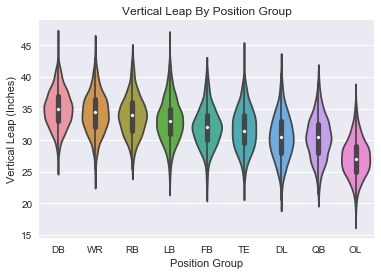

In [49]:
#Create a violinplot for vertical leap, grouped by position
VL_df_pos = df_joined[['Pos', 'Vert_Leap']].dropna()

sns.set()
_ = sns.violinplot('Pos', 'Vert_Leap', data = VL_df_pos, order = ['DB', 'WR', 'RB', 'LB', 'FB', 'TE', 'DL', 'QB', 'OL'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Vertical Leap (Inches)')
_ = plt.title('Vertical Leap By Position Group')
_ = plt.show()

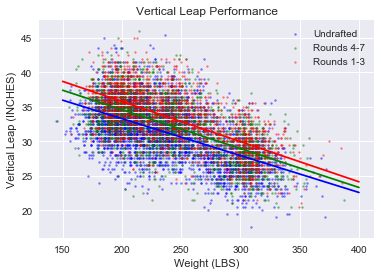

Regression for Undrafted: y=-0.0536168537776x + 44.012608899, R-Squared = 0.322149683799
Regression for Rounds 4-7: y=-0.0564814405621x + 45.8849808328, R-Squared = 0.387494438936
Regression for Rounds 1-3: y=-0.0583316306363x + 47.4489584839, R-Squared = 0.413745200669


In [50]:
#Create a scatterplot of vertical leap against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

VL_13 = df_joined[['Weight', 'Vert_Leap', 'Rnd']].dropna()
VL_13 = VL_13[VL_13['Rnd'] == '1-3']

VL_47 = df_joined[['Weight', 'Vert_Leap', 'Rnd']].dropna()
VL_47 = VL_47[VL_47['Rnd'] == '4-7']

VL_Undrafted = df_joined[['Weight', 'Vert_Leap', 'Rnd']].dropna()
VL_Undrafted = VL_Undrafted[VL_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_VL_Undrafted, b_VL_Undrafted = np.polyfit(VL_Undrafted['Weight'], VL_Undrafted['Vert_Leap'], deg=1)
m_VL_47, b_VL_47 = np.polyfit(VL_47['Weight'], VL_47['Vert_Leap'], deg=1)
m_VL_13, b_VL_13 = np.polyfit(VL_13['Weight'], VL_13['Vert_Leap'], deg=1)


#calculate R squared of each group
VL_rsquared_Undrafted = rsquared(VL_Undrafted['Weight'], VL_Undrafted['Vert_Leap'])
VL_rsquared_47 = rsquared(VL_47['Weight'], VL_47['Vert_Leap'])
VL_rsquared_13 = rsquared(VL_13['Weight'], VL_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_VL_Undrafted*x + b_VL_Undrafted, color = 'blue')
_ = plt.plot(x, m_VL_47*x + b_VL_47, color = 'green')
_ = plt.plot(x, m_VL_13*x + b_VL_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = VL_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = VL_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = VL_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])
plt.title('Vertical Leap Performance')
plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_VL_Undrafted) + 'x + ' + str(b_VL_Undrafted)  + ', R-Squared = ' + str(VL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_VL_47) + 'x + ' + str(b_VL_47) + ', R-Squared = ' + str(VL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_VL_13) + 'x + ' + str(b_VL_13) + ', R-Squared = ' + str(VL_rsquared_13))

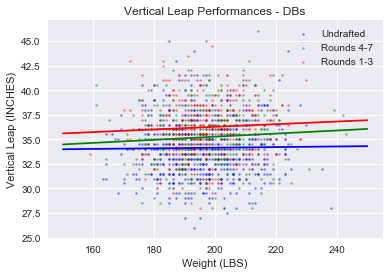

Regression for Undrafted: y=0.00310840605837x + 33.5192898972, R-Squared = 0.00019844577731
Regression for Rounds 4-7: y=0.0157548879109x + 32.1101183431, R-Squared = 0.0050422795161
Regression for Rounds 1-3: y=0.0134239535837x + 33.5812722096, R-Squared = 0.00294892890301


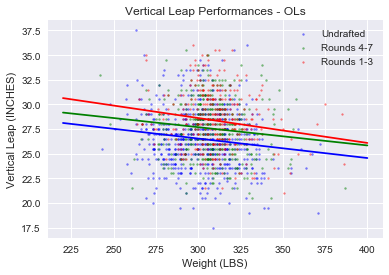

Regression for Undrafted: y=-0.0197627691514x + 32.4628352436, R-Squared = 0.0184931504755
Regression for Rounds 4-7: y=-0.0185255504427x + 33.2463405414, R-Squared = 0.0122426876905
Regression for Rounds 1-3: y=-0.025278363642x + 36.2006982069, R-Squared = 0.0252049675267


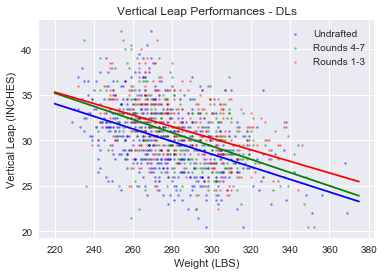

Regression for Undrafted: y=-0.0692870520241x + 49.2748421198, R-Squared = 0.202170804999
Regression for Rounds 4-7: y=-0.072789599525x + 51.2142183185, R-Squared = 0.214685159476
Regression for Rounds 1-3: y=-0.0634714187017x + 49.2778416757, R-Squared = 0.18956972092


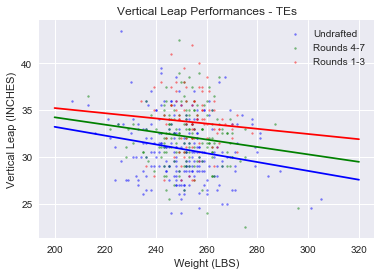

Regression for Undrafted: y=-0.0471429103823x + 42.636432126, R-Squared = 0.0416999716617
Regression for Rounds 4-7: y=-0.0396930577299x + 42.1661071438, R-Squared = 0.0224394592473
Regression for Rounds 1-3: y=-0.0277537148196x + 40.7659157322, R-Squared = 0.00558380236101


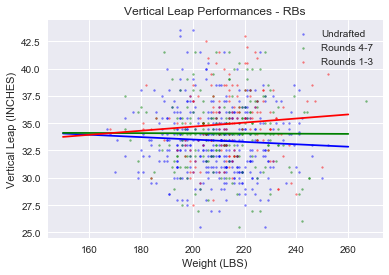

Regression for Undrafted: y=-0.0109874954295x + 35.7017013682, R-Squared = 0.00290327631648
Regression for Rounds 4-7: y=-0.000859253131428x + 34.2411014206, R-Squared = 1.75092520419e-05
Regression for Rounds 1-3: y=0.0186727141918x + 30.944700247, R-Squared = 0.00720592488209


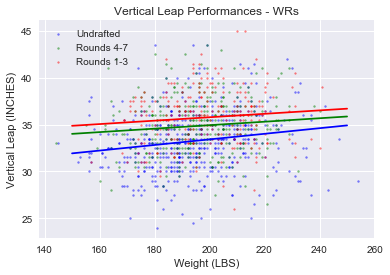

Regression for Undrafted: y=0.0298699563428x + 27.4535030626, R-Squared = 0.0282138672647
Regression for Rounds 4-7: y=0.0185319129348x + 31.2378417008, R-Squared = 0.010110607135
Regression for Rounds 1-3: y=0.0182831414291x + 32.1364437664, R-Squared = 0.00920324996706


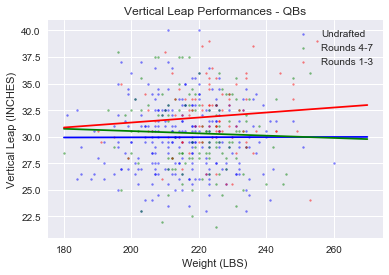

Regression for Undrafted: y=0.000595002283236x + 29.8148944295, R-Squared = 5.93623713181e-06
Regression for Rounds 4-7: y=-0.0107787299729x + 32.6804473581, R-Squared = 0.00136185605049
Regression for Rounds 1-3: y=0.0234863134309x + 26.6314995188, R-Squared = 0.00918461625492


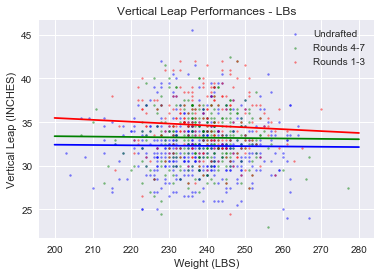

Regression for Undrafted: y=-0.00338387745569x + 33.0893896564, R-Squared = 0.000136993952984
Regression for Rounds 4-7: y=-0.00436273099485x + 34.2590396925, R-Squared = 0.000173680033219
Regression for Rounds 1-3: y=-0.021468824919x + 39.7675297651, R-Squared = 0.00401106071624


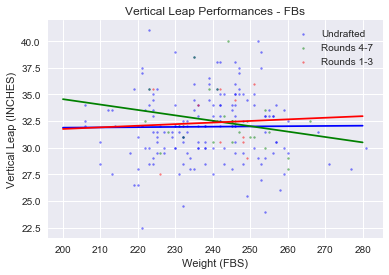

Regression for Undrafted: y=0.00230023008133x + 31.4190123843, R-Squared = 0.000102643225288
Regression for Rounds 4-7: y=-0.0506605820781x + 44.6826972173, R-Squared = 0.0555795950581
Regression for Rounds 1-3: y=0.0149748743719x + 28.7642211055, R-Squared = 0.00241347353316


In [59]:
#Scatterplot for DB Group - Vert_Leap
Vert_Leap_db_weight_13 = df_DB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_db_weight_13 = Vert_Leap_db_weight_13[Vert_Leap_db_weight_13['Rnd'] == '1-3']

Vert_Leap_db_weight_47 = df_DB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_db_weight_47 = Vert_Leap_db_weight_47[Vert_Leap_db_weight_47['Rnd'] == '4-7']

Vert_Leap_db_weight_Undrafted = df_DB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_db_weight_Undrafted = Vert_Leap_db_weight_Undrafted[Vert_Leap_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(Vert_Leap_db_weight_Undrafted['Weight'], Vert_Leap_db_weight_Undrafted['Vert_Leap'], deg=1)
m_db_47, b_db_47 = np.polyfit(Vert_Leap_db_weight_47['Weight'], Vert_Leap_db_weight_47['Vert_Leap'], deg=1)
m_db_13, b_db_13 = np.polyfit(Vert_Leap_db_weight_13['Weight'], Vert_Leap_db_weight_13['Vert_Leap'], deg=1)

Vert_Leap_db_rsquared_Undrafted = rsquared(Vert_Leap_db_weight_Undrafted['Weight'], Vert_Leap_db_weight_Undrafted['Vert_Leap'])
Vert_Leap_db_rsquared_47 = rsquared(Vert_Leap_db_weight_47['Weight'], Vert_Leap_db_weight_47['Vert_Leap'])
Vert_Leap_db_rsquared_13 = rsquared(Vert_Leap_db_weight_13['Weight'], Vert_Leap_db_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(Vert_Leap_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(Vert_Leap_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(Vert_Leap_db_rsquared_13))


#Scatterplot for OL Group
Vert_Leap_OL_weight_13 = df_OL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_OL_weight_13 = Vert_Leap_OL_weight_13[Vert_Leap_OL_weight_13['Rnd'] == '1-3']

Vert_Leap_OL_weight_47 = df_OL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_OL_weight_47 = Vert_Leap_OL_weight_47[Vert_Leap_OL_weight_47['Rnd'] == '4-7']

Vert_Leap_OL_weight_Undrafted = df_OL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_OL_weight_Undrafted = Vert_Leap_OL_weight_Undrafted[Vert_Leap_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(Vert_Leap_OL_weight_Undrafted['Weight'], Vert_Leap_OL_weight_Undrafted['Vert_Leap'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(Vert_Leap_OL_weight_47['Weight'], Vert_Leap_OL_weight_47['Vert_Leap'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(Vert_Leap_OL_weight_13['Weight'], Vert_Leap_OL_weight_13['Vert_Leap'], deg=1)

Vert_Leap_OL_rsquared_Undrafted = rsquared(Vert_Leap_OL_weight_Undrafted['Weight'], Vert_Leap_OL_weight_Undrafted['Vert_Leap'])
Vert_Leap_OL_rsquared_47 = rsquared(Vert_Leap_OL_weight_47['Weight'], Vert_Leap_OL_weight_47['Vert_Leap'])
Vert_Leap_OL_rsquared_13 = rsquared(Vert_Leap_OL_weight_13['Weight'], Vert_Leap_OL_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(Vert_Leap_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(Vert_Leap_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(Vert_Leap_OL_rsquared_13))


#scatterplot for Vert_Leap for DL Group
Vert_Leap_DL_weight_13 = df_DL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_DL_weight_13 = Vert_Leap_DL_weight_13[Vert_Leap_DL_weight_13['Rnd'] == '1-3']

Vert_Leap_DL_weight_47 = df_DL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_DL_weight_47 = Vert_Leap_DL_weight_47[Vert_Leap_DL_weight_47['Rnd'] == '4-7']

Vert_Leap_DL_weight_Undrafted = df_DL[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_DL_weight_Undrafted = Vert_Leap_DL_weight_Undrafted[Vert_Leap_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(Vert_Leap_DL_weight_Undrafted['Weight'], Vert_Leap_DL_weight_Undrafted['Vert_Leap'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(Vert_Leap_DL_weight_47['Weight'], Vert_Leap_DL_weight_47['Vert_Leap'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(Vert_Leap_DL_weight_13['Weight'], Vert_Leap_DL_weight_13['Vert_Leap'], deg=1)

Vert_Leap_DL_rsquared_Undrafted = rsquared(Vert_Leap_DL_weight_Undrafted['Weight'], Vert_Leap_DL_weight_Undrafted['Vert_Leap'])
Vert_Leap_DL_rsquared_47 = rsquared(Vert_Leap_DL_weight_47['Weight'], Vert_Leap_DL_weight_47['Vert_Leap'])
Vert_Leap_DL_rsquared_13 = rsquared(Vert_Leap_DL_weight_13['Weight'], Vert_Leap_DL_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(Vert_Leap_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(Vert_Leap_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(Vert_Leap_DL_rsquared_13))

#scatterplot for Vert_Leap for TE Group
Vert_Leap_TE_weight_13 = df_TE[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_TE_weight_13 = Vert_Leap_TE_weight_13[Vert_Leap_TE_weight_13['Rnd'] == '1-3']

Vert_Leap_TE_weight_47 = df_TE[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_TE_weight_47 = Vert_Leap_TE_weight_47[Vert_Leap_TE_weight_47['Rnd'] == '4-7']

Vert_Leap_TE_weight_Undrafted = df_TE[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_TE_weight_Undrafted = Vert_Leap_TE_weight_Undrafted[Vert_Leap_TE_weight_Undrafted['Rnd'] == 'Undrafted']
Vert_Leap_TE_weight_Undrafted = Vert_Leap_TE_weight_Undrafted[Vert_Leap_TE_weight_Undrafted['Weight'] > 180]
Vert_Leap_TE_weight_Undrafted = Vert_Leap_TE_weight_Undrafted[Vert_Leap_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([200,320])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (Vert_Leap_TE_weight_Undrafted['Weight'], Vert_Leap_TE_weight_Undrafted['Vert_Leap'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(Vert_Leap_TE_weight_47['Weight'], Vert_Leap_TE_weight_47['Vert_Leap'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (Vert_Leap_TE_weight_13['Weight'], Vert_Leap_TE_weight_13['Vert_Leap'], deg=1)

Vert_Leap_TE_rsquared_Undrafted = rsquared(Vert_Leap_TE_weight_Undrafted['Weight'], Vert_Leap_TE_weight_Undrafted['Vert_Leap'])
Vert_Leap_TE_rsquared_47 = rsquared(Vert_Leap_TE_weight_47['Weight'], Vert_Leap_TE_weight_47['Vert_Leap'])
Vert_Leap_TE_rsquared_13 = rsquared(Vert_Leap_TE_weight_13['Weight'], Vert_Leap_TE_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(Vert_Leap_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(Vert_Leap_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(Vert_Leap_TE_rsquared_13))


#scatterplot for Vert_Leap for RB Group
Vert_Leap_RB_weight_13 = df_RB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_RB_weight_13 = Vert_Leap_RB_weight_13[Vert_Leap_RB_weight_13['Rnd'] == '1-3']

Vert_Leap_RB_weight_47 = df_RB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_RB_weight_47 = Vert_Leap_RB_weight_47[Vert_Leap_RB_weight_47['Rnd'] == '4-7']

Vert_Leap_RB_weight_Undrafted = df_RB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_RB_weight_Undrafted = Vert_Leap_RB_weight_Undrafted[Vert_Leap_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,260])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (Vert_Leap_RB_weight_Undrafted ['Weight'], Vert_Leap_RB_weight_Undrafted ['Vert_Leap'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(Vert_Leap_RB_weight_47['Weight'], Vert_Leap_RB_weight_47['Vert_Leap'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (Vert_Leap_RB_weight_13['Weight'], Vert_Leap_RB_weight_13['Vert_Leap'], deg=1)

Vert_Leap_RB_rsquared_Undrafted = rsquared(Vert_Leap_RB_weight_Undrafted['Weight'], Vert_Leap_RB_weight_Undrafted['Vert_Leap'])
Vert_Leap_RB_rsquared_47 = rsquared(Vert_Leap_RB_weight_47['Weight'], Vert_Leap_RB_weight_47['Vert_Leap'])
Vert_Leap_RB_rsquared_13 = rsquared(Vert_Leap_RB_weight_13['Weight'], Vert_Leap_RB_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(Vert_Leap_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(Vert_Leap_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(Vert_Leap_RB_rsquared_13))


#scatterplot for Vert_Leap for WR Group
Vert_Leap_WR_weight_13 = df_WR[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_WR_weight_13 = Vert_Leap_WR_weight_13[Vert_Leap_WR_weight_13['Rnd'] == '1-3']

Vert_Leap_WR_weight_47 = df_WR[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_WR_weight_47 = Vert_Leap_WR_weight_47[Vert_Leap_WR_weight_47['Rnd'] == '4-7']

Vert_Leap_WR_weight_Undrafted = df_WR[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_WR_weight_Undrafted = Vert_Leap_WR_weight_Undrafted[Vert_Leap_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (Vert_Leap_WR_weight_Undrafted ['Weight'], Vert_Leap_WR_weight_Undrafted ['Vert_Leap'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(Vert_Leap_WR_weight_47['Weight'], Vert_Leap_WR_weight_47['Vert_Leap'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (Vert_Leap_WR_weight_13['Weight'], Vert_Leap_WR_weight_13['Vert_Leap'], deg=1)

Vert_Leap_WR_rsquared_Undrafted = rsquared(Vert_Leap_WR_weight_Undrafted['Weight'], Vert_Leap_WR_weight_Undrafted['Vert_Leap'])
Vert_Leap_WR_rsquared_47 = rsquared(Vert_Leap_WR_weight_47['Weight'], Vert_Leap_WR_weight_47['Vert_Leap'])
Vert_Leap_WR_rsquared_13 = rsquared(Vert_Leap_WR_weight_13['Weight'], Vert_Leap_WR_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(Vert_Leap_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(Vert_Leap_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(Vert_Leap_WR_rsquared_13))


#scatterplot for Vert_Leap for QB Group
Vert_Leap_QB_weight_13 = df_QB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_QB_weight_13 = Vert_Leap_QB_weight_13[Vert_Leap_QB_weight_13['Rnd'] == '1-3']

Vert_Leap_QB_weight_47 = df_QB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_QB_weight_47 = Vert_Leap_QB_weight_47[Vert_Leap_QB_weight_47['Rnd'] == '4-7']

Vert_Leap_QB_weight_Undrafted = df_QB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_QB_weight_Undrafted = Vert_Leap_QB_weight_Undrafted[Vert_Leap_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (Vert_Leap_QB_weight_Undrafted ['Weight'], Vert_Leap_QB_weight_Undrafted ['Vert_Leap'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(Vert_Leap_QB_weight_47['Weight'], Vert_Leap_QB_weight_47['Vert_Leap'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (Vert_Leap_QB_weight_13['Weight'], Vert_Leap_QB_weight_13['Vert_Leap'], deg=1)

Vert_Leap_QB_rsquared_Undrafted = rsquared(Vert_Leap_QB_weight_Undrafted['Weight'], Vert_Leap_QB_weight_Undrafted['Vert_Leap'])
Vert_Leap_QB_rsquared_47 = rsquared(Vert_Leap_QB_weight_47['Weight'], Vert_Leap_QB_weight_47['Vert_Leap'])
Vert_Leap_QB_rsquared_13 = rsquared(Vert_Leap_QB_weight_13['Weight'], Vert_Leap_QB_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(Vert_Leap_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(Vert_Leap_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(Vert_Leap_QB_rsquared_13))

#scatterplot for Vert_Leap for LB Group
Vert_Leap_LB_weight_13 = df_LB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_LB_weight_13 = Vert_Leap_LB_weight_13[Vert_Leap_LB_weight_13['Rnd'] == '1-3']

Vert_Leap_LB_weight_47 = df_LB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_LB_weight_47 = Vert_Leap_LB_weight_47[Vert_Leap_LB_weight_47['Rnd'] == '4-7']

Vert_Leap_LB_weight_Undrafted = df_LB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_LB_weight_Undrafted = Vert_Leap_LB_weight_Undrafted[Vert_Leap_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (Vert_Leap_LB_weight_Undrafted ['Weight'], Vert_Leap_LB_weight_Undrafted ['Vert_Leap'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(Vert_Leap_LB_weight_47['Weight'], Vert_Leap_LB_weight_47['Vert_Leap'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (Vert_Leap_LB_weight_13['Weight'], Vert_Leap_LB_weight_13['Vert_Leap'], deg=1)

Vert_Leap_LB_rsquared_Undrafted = rsquared(Vert_Leap_LB_weight_Undrafted['Weight'], Vert_Leap_LB_weight_Undrafted['Vert_Leap'])
Vert_Leap_LB_rsquared_47 = rsquared(Vert_Leap_LB_weight_47['Weight'], Vert_Leap_LB_weight_47['Vert_Leap'])
Vert_Leap_LB_rsquared_13 = rsquared(Vert_Leap_LB_weight_13['Weight'], Vert_Leap_LB_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(Vert_Leap_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(Vert_Leap_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(Vert_Leap_LB_rsquared_13))

#scatterplot for Vert_Leap for FB Group
Vert_Leap_FB_weight_13 = df_FB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_FB_weight_13 = Vert_Leap_FB_weight_13[Vert_Leap_FB_weight_13['Rnd'] == '1-3']

Vert_Leap_FB_weight_47 = df_FB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_FB_weight_47 = Vert_Leap_FB_weight_47[Vert_Leap_FB_weight_47['Rnd'] == '4-7']

Vert_Leap_FB_weight_Undrafted = df_FB[['Weight', 'Vert_Leap', 'Rnd']].dropna()
Vert_Leap_FB_weight_Undrafted = Vert_Leap_FB_weight_Undrafted[Vert_Leap_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (Vert_Leap_FB_weight_Undrafted ['Weight'], Vert_Leap_FB_weight_Undrafted ['Vert_Leap'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(Vert_Leap_FB_weight_47['Weight'], Vert_Leap_FB_weight_47['Vert_Leap'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (Vert_Leap_FB_weight_13['Weight'], Vert_Leap_FB_weight_13['Vert_Leap'], deg=1)

Vert_Leap_FB_rsquared_Undrafted = rsquared(Vert_Leap_FB_weight_Undrafted['Weight'], Vert_Leap_FB_weight_Undrafted['Vert_Leap'])
Vert_Leap_FB_rsquared_47 = rsquared(Vert_Leap_FB_weight_47['Weight'], Vert_Leap_FB_weight_47['Vert_Leap'])
Vert_Leap_FB_rsquared_13 = rsquared(Vert_Leap_FB_weight_13['Weight'], Vert_Leap_FB_weight_13['Vert_Leap'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatFBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Vert_Leap', data = Vert_Leap_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (FBS)')
_ = plt.ylabel('Vertical Leap (INCHES)')
_ = plt.title('Vertical Leap Performances - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(Vert_Leap_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(Vert_Leap_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(Vert_Leap_FB_rsquared_13))



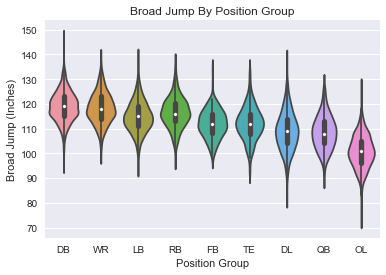

In [53]:
#Create a violinplot for broad jump, grouped by position
BJ_df_pos = df_joined[['Pos', 'Broad_Jump']].dropna()

#Eliminate outliers of 7 and 8 inch broad jumps, which make no intuitive sense
BJ_df_pos = BJ_df_pos[BJ_df_pos['Broad_Jump'] != 7]
BJ_df_pos = BJ_df_pos[BJ_df_pos['Broad_Jump'] != 8]

sns.set()
_ = sns.violinplot('Pos', 'Broad_Jump', data = BJ_df_pos, order = ['DB', 'WR', 'LB', 'RB', 'FB', 'TE', 'DL', 'QB', 'OL'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Broad Jump (Inches)')
_ = plt.title('Broad Jump By Position Group')
_ = plt.show()


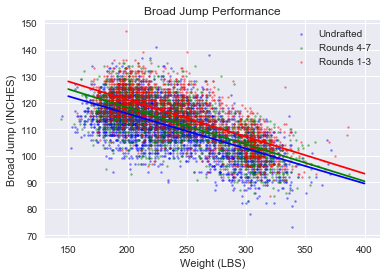

Regression for Undrafted: y=-0.131648514237x + 142.187736379, R-Squared = 0.406508999602
Regression for Rounds 4-7: y=-0.138916859363x + 145.950052982, R-Squared = 0.480538398554
Regression for Rounds 1-3: y=-0.1390566185x + 148.871806318, R-Squared = 0.48479637544


In [54]:
#Create a scatterplot of Broad Jump against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

BJ_13 = df_joined[['Weight', 'Broad_Jump', 'Rnd']].dropna()
BJ_13 = BJ_13[BJ_13['Rnd'] == '1-3']

BJ_47 = df_joined[['Weight', 'Broad_Jump', 'Rnd']].dropna()
BJ_47 = BJ_47[BJ_47['Rnd'] == '4-7']
BJ_47 = BJ_47[BJ_47['Broad_Jump'] >= 20]

BJ_Undrafted = df_joined[['Weight', 'Broad_Jump', 'Rnd']].dropna()
BJ_Undrafted = BJ_Undrafted[BJ_Undrafted['Rnd'] == 'Undrafted']
BJ_Undrafted = BJ_Undrafted[BJ_Undrafted['Broad_Jump'] >= 20]


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_BJ_Undrafted, b_BJ_Undrafted = np.polyfit(BJ_Undrafted['Weight'], BJ_Undrafted['Broad_Jump'], deg=1)
m_BJ_47, b_BJ_47 = np.polyfit(BJ_47['Weight'], BJ_47['Broad_Jump'], deg=1)
m_BJ_13, b_BJ_13 = np.polyfit(BJ_13['Weight'], BJ_13['Broad_Jump'], deg=1)


#calculate R squared of each group
BJ_rsquared_Undrafted = rsquared(BJ_Undrafted['Weight'], BJ_Undrafted['Broad_Jump'])
BJ_rsquared_47 = rsquared(BJ_47['Weight'], BJ_47['Broad_Jump'])
BJ_rsquared_13 = rsquared(BJ_13['Weight'], BJ_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_BJ_Undrafted*x + b_BJ_Undrafted, color = 'blue')
_ = plt.plot(x, m_BJ_47*x + b_BJ_47, color = 'green')
_ = plt.plot(x, m_BJ_13*x + b_BJ_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = BJ_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = BJ_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = BJ_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])
plt.title('Broad Jump Performance')
plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_BJ_Undrafted) + 'x + ' + str(b_BJ_Undrafted)  + ', R-Squared = ' + str(BJ_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_BJ_47) + 'x + ' + str(b_BJ_47) + ', R-Squared = ' + str(BJ_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_BJ_13) + 'x + ' + str(b_BJ_13) + ', R-Squared = ' + str(BJ_rsquared_13))


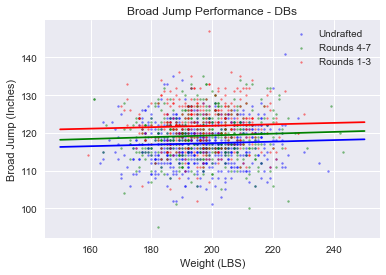

Regression for Undrafted: y=0.0201884051063x + 113.229459836, R-Squared = 0.00237690114587
Regression for Rounds 4-7: y=0.0232283451359x + 114.674023086, R-Squared = 0.00264242581656
Regression for Rounds 1-3: y=0.0190135088153x + 118.074984214, R-Squared = 0.00143028692172


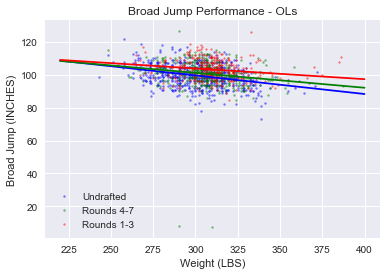

Regression for Undrafted: y=-0.112943245978x + 133.529864049, R-Squared = 0.107949968861
Regression for Rounds 4-7: y=-0.0907045306888x + 128.446393507, R-Squared = 0.0295492214401
Regression for Rounds 1-3: y=-0.0651580786227x + 123.455395803, R-Squared = 0.0350538582401


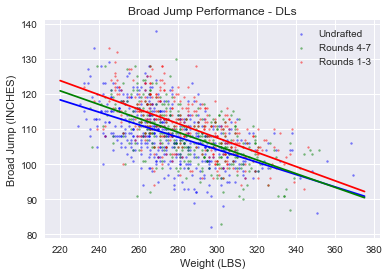

Regression for Undrafted: y=-0.177135039891x + 157.280181299, R-Squared = 0.282930395272
Regression for Rounds 4-7: y=-0.196412580414x + 164.096049479, R-Squared = 0.349873720343
Regression for Rounds 1-3: y=-0.203892690147x + 168.655016059, R-Squared = 0.359690124837


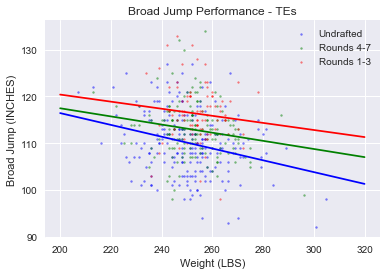

In [ ]:
#Scatterplot for DB Group - Broad_Jump
Broad_Jump_db_weight_13 = df_DB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_db_weight_13 = Broad_Jump_db_weight_13[Broad_Jump_db_weight_13['Rnd'] == '1-3']

Broad_Jump_db_weight_47 = df_DB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_db_weight_47 = Broad_Jump_db_weight_47[Broad_Jump_db_weight_47['Rnd'] == '4-7']

Broad_Jump_db_weight_Undrafted = df_DB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_db_weight_Undrafted = Broad_Jump_db_weight_Undrafted[Broad_Jump_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(Broad_Jump_db_weight_Undrafted['Weight'], Broad_Jump_db_weight_Undrafted['Broad_Jump'], deg=1)
m_db_47, b_db_47 = np.polyfit(Broad_Jump_db_weight_47['Weight'], Broad_Jump_db_weight_47['Broad_Jump'], deg=1)
m_db_13, b_db_13 = np.polyfit(Broad_Jump_db_weight_13['Weight'], Broad_Jump_db_weight_13['Broad_Jump'], deg=1)

Broad_Jump_db_rsquared_Undrafted = rsquared(Broad_Jump_db_weight_Undrafted['Weight'], Broad_Jump_db_weight_Undrafted['Broad_Jump'])
Broad_Jump_db_rsquared_47 = rsquared(Broad_Jump_db_weight_47['Weight'], Broad_Jump_db_weight_47['Broad_Jump'])
Broad_Jump_db_rsquared_13 = rsquared(Broad_Jump_db_weight_13['Weight'], Broad_Jump_db_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (Inches)')
_ = plt.title('Broad Jump Performance - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(Broad_Jump_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(Broad_Jump_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(Broad_Jump_db_rsquared_13))


#Scatterplot for OL Group
Broad_Jump_OL_weight_13 = df_OL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_OL_weight_13 = Broad_Jump_OL_weight_13[Broad_Jump_OL_weight_13['Rnd'] == '1-3']

Broad_Jump_OL_weight_47 = df_OL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_OL_weight_47 = Broad_Jump_OL_weight_47[Broad_Jump_OL_weight_47['Rnd'] == '4-7']

Broad_Jump_OL_weight_Undrafted = df_OL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_OL_weight_Undrafted = Broad_Jump_OL_weight_Undrafted[Broad_Jump_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(Broad_Jump_OL_weight_Undrafted['Weight'], Broad_Jump_OL_weight_Undrafted['Broad_Jump'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(Broad_Jump_OL_weight_47['Weight'], Broad_Jump_OL_weight_47['Broad_Jump'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(Broad_Jump_OL_weight_13['Weight'], Broad_Jump_OL_weight_13['Broad_Jump'], deg=1)

Broad_Jump_OL_rsquared_Undrafted = rsquared(Broad_Jump_OL_weight_Undrafted['Weight'], Broad_Jump_OL_weight_Undrafted['Broad_Jump'])
Broad_Jump_OL_rsquared_47 = rsquared(Broad_Jump_OL_weight_47['Weight'], Broad_Jump_OL_weight_47['Broad_Jump'])
Broad_Jump_OL_rsquared_13 = rsquared(Broad_Jump_OL_weight_13['Weight'], Broad_Jump_OL_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(Broad_Jump_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(Broad_Jump_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(Broad_Jump_OL_rsquared_13))


#scatterplot for Broad_Jump for DL Group
Broad_Jump_DL_weight_13 = df_DL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_DL_weight_13 = Broad_Jump_DL_weight_13[Broad_Jump_DL_weight_13['Rnd'] == '1-3']

Broad_Jump_DL_weight_47 = df_DL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_DL_weight_47 = Broad_Jump_DL_weight_47[Broad_Jump_DL_weight_47['Rnd'] == '4-7']

Broad_Jump_DL_weight_Undrafted = df_DL[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_DL_weight_Undrafted = Broad_Jump_DL_weight_Undrafted[Broad_Jump_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(Broad_Jump_DL_weight_Undrafted['Weight'], Broad_Jump_DL_weight_Undrafted['Broad_Jump'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(Broad_Jump_DL_weight_47['Weight'], Broad_Jump_DL_weight_47['Broad_Jump'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(Broad_Jump_DL_weight_13['Weight'], Broad_Jump_DL_weight_13['Broad_Jump'], deg=1)

Broad_Jump_DL_rsquared_Undrafted = rsquared(Broad_Jump_DL_weight_Undrafted['Weight'], Broad_Jump_DL_weight_Undrafted['Broad_Jump'])
Broad_Jump_DL_rsquared_47 = rsquared(Broad_Jump_DL_weight_47['Weight'], Broad_Jump_DL_weight_47['Broad_Jump'])
Broad_Jump_DL_rsquared_13 = rsquared(Broad_Jump_DL_weight_13['Weight'], Broad_Jump_DL_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(Broad_Jump_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(Broad_Jump_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(Broad_Jump_DL_rsquared_13))

#scatterplot for Broad_Jump for TE Group
Broad_Jump_TE_weight_13 = df_TE[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_TE_weight_13 = Broad_Jump_TE_weight_13[Broad_Jump_TE_weight_13['Rnd'] == '1-3']

Broad_Jump_TE_weight_47 = df_TE[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_TE_weight_47 = Broad_Jump_TE_weight_47[Broad_Jump_TE_weight_47['Rnd'] == '4-7']

Broad_Jump_TE_weight_Undrafted = df_TE[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_TE_weight_Undrafted = Broad_Jump_TE_weight_Undrafted[Broad_Jump_TE_weight_Undrafted['Rnd'] == 'Undrafted']
Broad_Jump_TE_weight_Undrafted = Broad_Jump_TE_weight_Undrafted[Broad_Jump_TE_weight_Undrafted['Weight'] > 180]
Broad_Jump_TE_weight_Undrafted = Broad_Jump_TE_weight_Undrafted[Broad_Jump_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([200,320])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (Broad_Jump_TE_weight_Undrafted['Weight'], Broad_Jump_TE_weight_Undrafted['Broad_Jump'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(Broad_Jump_TE_weight_47['Weight'], Broad_Jump_TE_weight_47['Broad_Jump'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (Broad_Jump_TE_weight_13['Weight'], Broad_Jump_TE_weight_13['Broad_Jump'], deg=1)

Broad_Jump_TE_rsquared_Undrafted = rsquared(Broad_Jump_TE_weight_Undrafted['Weight'], Broad_Jump_TE_weight_Undrafted['Broad_Jump'])
Broad_Jump_TE_rsquared_47 = rsquared(Broad_Jump_TE_weight_47['Weight'], Broad_Jump_TE_weight_47['Broad_Jump'])
Broad_Jump_TE_rsquared_13 = rsquared(Broad_Jump_TE_weight_13['Weight'], Broad_Jump_TE_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(Broad_Jump_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(Broad_Jump_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(Broad_Jump_TE_rsquared_13))


#scatterplot for Broad_Jump for RB Group
Broad_Jump_RB_weight_13 = df_RB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_RB_weight_13 = Broad_Jump_RB_weight_13[Broad_Jump_RB_weight_13['Rnd'] == '1-3']

Broad_Jump_RB_weight_47 = df_RB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_RB_weight_47 = Broad_Jump_RB_weight_47[Broad_Jump_RB_weight_47['Rnd'] == '4-7']

Broad_Jump_RB_weight_Undrafted = df_RB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_RB_weight_Undrafted = Broad_Jump_RB_weight_Undrafted[Broad_Jump_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,260])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (Broad_Jump_RB_weight_Undrafted ['Weight'], Broad_Jump_RB_weight_Undrafted ['Broad_Jump'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(Broad_Jump_RB_weight_47['Weight'], Broad_Jump_RB_weight_47['Broad_Jump'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (Broad_Jump_RB_weight_13['Weight'], Broad_Jump_RB_weight_13['Broad_Jump'], deg=1)

Broad_Jump_RB_rsquared_Undrafted = rsquared(Broad_Jump_RB_weight_Undrafted['Weight'], Broad_Jump_RB_weight_Undrafted['Broad_Jump'])
Broad_Jump_RB_rsquared_47 = rsquared(Broad_Jump_RB_weight_47['Weight'], Broad_Jump_RB_weight_47['Broad_Jump'])
Broad_Jump_RB_rsquared_13 = rsquared(Broad_Jump_RB_weight_13['Weight'], Broad_Jump_RB_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(Broad_Jump_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(Broad_Jump_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(Broad_Jump_RB_rsquared_13))


#scatterplot for Broad_Jump for WR Group
Broad_Jump_WR_weight_13 = df_WR[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_WR_weight_13 = Broad_Jump_WR_weight_13[Broad_Jump_WR_weight_13['Rnd'] == '1-3']

Broad_Jump_WR_weight_47 = df_WR[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_WR_weight_47 = Broad_Jump_WR_weight_47[Broad_Jump_WR_weight_47['Rnd'] == '4-7']

Broad_Jump_WR_weight_Undrafted = df_WR[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_WR_weight_Undrafted = Broad_Jump_WR_weight_Undrafted[Broad_Jump_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (Broad_Jump_WR_weight_Undrafted ['Weight'], Broad_Jump_WR_weight_Undrafted ['Broad_Jump'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(Broad_Jump_WR_weight_47['Weight'], Broad_Jump_WR_weight_47['Broad_Jump'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (Broad_Jump_WR_weight_13['Weight'], Broad_Jump_WR_weight_13['Broad_Jump'], deg=1)

Broad_Jump_WR_rsquared_Undrafted = rsquared(Broad_Jump_WR_weight_Undrafted['Weight'], Broad_Jump_WR_weight_Undrafted['Broad_Jump'])
Broad_Jump_WR_rsquared_47 = rsquared(Broad_Jump_WR_weight_47['Weight'], Broad_Jump_WR_weight_47['Broad_Jump'])
Broad_Jump_WR_rsquared_13 = rsquared(Broad_Jump_WR_weight_13['Weight'], Broad_Jump_WR_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(Broad_Jump_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(Broad_Jump_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(Broad_Jump_WR_rsquared_13))


#scatterplot for Broad_Jump for QB Group
Broad_Jump_QB_weight_13 = df_QB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_QB_weight_13 = Broad_Jump_QB_weight_13[Broad_Jump_QB_weight_13['Rnd'] == '1-3']

Broad_Jump_QB_weight_47 = df_QB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_QB_weight_47 = Broad_Jump_QB_weight_47[Broad_Jump_QB_weight_47['Rnd'] == '4-7']

Broad_Jump_QB_weight_Undrafted = df_QB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_QB_weight_Undrafted = Broad_Jump_QB_weight_Undrafted[Broad_Jump_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (Broad_Jump_QB_weight_Undrafted ['Weight'], Broad_Jump_QB_weight_Undrafted ['Broad_Jump'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(Broad_Jump_QB_weight_47['Weight'], Broad_Jump_QB_weight_47['Broad_Jump'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (Broad_Jump_QB_weight_13['Weight'], Broad_Jump_QB_weight_13['Broad_Jump'], deg=1)

Broad_Jump_QB_rsquared_Undrafted = rsquared(Broad_Jump_QB_weight_Undrafted['Weight'], Broad_Jump_QB_weight_Undrafted['Broad_Jump'])
Broad_Jump_QB_rsquared_47 = rsquared(Broad_Jump_QB_weight_47['Weight'], Broad_Jump_QB_weight_47['Broad_Jump'])
Broad_Jump_QB_rsquared_13 = rsquared(Broad_Jump_QB_weight_13['Weight'], Broad_Jump_QB_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(Broad_Jump_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(Broad_Jump_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(Broad_Jump_QB_rsquared_13))

#scatterplot for Broad_Jump for LB Group
Broad_Jump_LB_weight_13 = df_LB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_LB_weight_13 = Broad_Jump_LB_weight_13[Broad_Jump_LB_weight_13['Rnd'] == '1-3']

Broad_Jump_LB_weight_47 = df_LB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_LB_weight_47 = Broad_Jump_LB_weight_47[Broad_Jump_LB_weight_47['Rnd'] == '4-7']

Broad_Jump_LB_weight_Undrafted = df_LB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_LB_weight_Undrafted = Broad_Jump_LB_weight_Undrafted[Broad_Jump_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (Broad_Jump_LB_weight_Undrafted ['Weight'], Broad_Jump_LB_weight_Undrafted ['Broad_Jump'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(Broad_Jump_LB_weight_47['Weight'], Broad_Jump_LB_weight_47['Broad_Jump'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (Broad_Jump_LB_weight_13['Weight'], Broad_Jump_LB_weight_13['Broad_Jump'], deg=1)

Broad_Jump_LB_rsquared_Undrafted = rsquared(Broad_Jump_LB_weight_Undrafted['Weight'], Broad_Jump_LB_weight_Undrafted['Broad_Jump'])
Broad_Jump_LB_rsquared_47 = rsquared(Broad_Jump_LB_weight_47['Weight'], Broad_Jump_LB_weight_47['Broad_Jump'])
Broad_Jump_LB_rsquared_13 = rsquared(Broad_Jump_LB_weight_13['Weight'], Broad_Jump_LB_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(Broad_Jump_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(Broad_Jump_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(Broad_Jump_LB_rsquared_13))

#scatterplot for Broad_Jump for FB Group
Broad_Jump_FB_weight_13 = df_FB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_FB_weight_13 = Broad_Jump_FB_weight_13[Broad_Jump_FB_weight_13['Rnd'] == '1-3']

Broad_Jump_FB_weight_47 = df_FB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_FB_weight_47 = Broad_Jump_FB_weight_47[Broad_Jump_FB_weight_47['Rnd'] == '4-7']

Broad_Jump_FB_weight_Undrafted = df_FB[['Weight', 'Broad_Jump', 'Rnd']].dropna()
Broad_Jump_FB_weight_Undrafted = Broad_Jump_FB_weight_Undrafted[Broad_Jump_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (Broad_Jump_FB_weight_Undrafted ['Weight'], Broad_Jump_FB_weight_Undrafted ['Broad_Jump'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(Broad_Jump_FB_weight_47['Weight'], Broad_Jump_FB_weight_47['Broad_Jump'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (Broad_Jump_FB_weight_13['Weight'], Broad_Jump_FB_weight_13['Broad_Jump'], deg=1)

Broad_Jump_FB_rsquared_Undrafted = rsquared(Broad_Jump_FB_weight_Undrafted['Weight'], Broad_Jump_FB_weight_Undrafted['Broad_Jump'])
Broad_Jump_FB_rsquared_47 = rsquared(Broad_Jump_FB_weight_47['Weight'], Broad_Jump_FB_weight_47['Broad_Jump'])
Broad_Jump_FB_rsquared_13 = rsquared(Broad_Jump_FB_weight_13['Weight'], Broad_Jump_FB_weight_13['Broad_Jump'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatFBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Broad_Jump', data = Broad_Jump_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Broad Jump (INCHES)')
_ = plt.title('Broad Jump Performance - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(Broad_Jump_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(Broad_Jump_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(Broad_Jump_FB_rsquared_13))



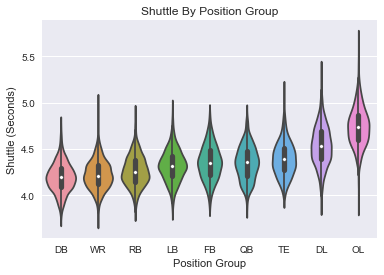

In [55]:
#Create a violinplot for Shuttle, grouped by position
Shuttle_df_pos = df_joined[['Pos', 'Shuttle']].dropna()

sns.set()
_ = sns.violinplot('Pos', 'Shuttle', data = Shuttle_df_pos, order = ['DB', 'WR', 'RB', 'LB', 'FB', 'QB', 'TE', 'DL', 'OL'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Shuttle (Seconds)')
_ = plt.title('Shuttle By Position Group')
_ = plt.show()

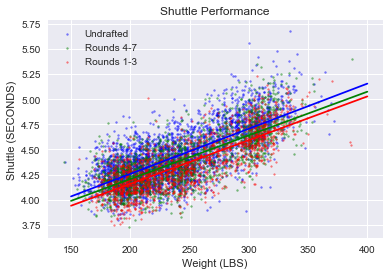

Regression for Undrafted: y=0.00448538963172x + 3.36067635371, R-Squared = 0.525759297723
Regression for Rounds 4-7: y=0.00434141153401x + 3.33806255836, R-Squared = 0.560587634565
Regression for Rounds 1-3: y=0.00434701351767x + 3.28884329144, R-Squared = 0.594110613151


In [56]:
#Create a scatterplot of Shuttle against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

Shuttle_13 = df_joined[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_13 = Shuttle_13[Shuttle_13['Rnd'] == '1-3']

Shuttle_47 = df_joined[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_47 = Shuttle_47[Shuttle_47['Rnd'] == '4-7']

Shuttle_Undrafted = df_joined[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_Undrafted = Shuttle_Undrafted[Shuttle_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_Shuttle_Undrafted, b_Shuttle_Undrafted = np.polyfit(Shuttle_Undrafted['Weight'], Shuttle_Undrafted['Shuttle'], deg=1)
m_Shuttle_47, b_Shuttle_47 = np.polyfit(Shuttle_47['Weight'], Shuttle_47['Shuttle'], deg=1)
m_Shuttle_13, b_Shuttle_13 = np.polyfit(Shuttle_13['Weight'], Shuttle_13['Shuttle'], deg=1)


#calculate R squared of each group
Shuttle_rsquared_Undrafted = rsquared(Shuttle_Undrafted['Weight'], Shuttle_Undrafted['Shuttle'])
Shuttle_rsquared_47 = rsquared(Shuttle_47['Weight'], Shuttle_47['Shuttle'])
Shuttle_rsquared_13 = rsquared(Shuttle_13['Weight'], Shuttle_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_Shuttle_Undrafted*x + b_Shuttle_Undrafted, color = 'blue')
_ = plt.plot(x, m_Shuttle_47*x + b_Shuttle_47, color = 'green')
_ = plt.plot(x, m_Shuttle_13*x + b_Shuttle_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])
plt.title('Shuttle Performance')
plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_Shuttle_Undrafted) + 'x + ' + str(b_Shuttle_Undrafted)  + ', R-Squared = ' + str(Shuttle_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_Shuttle_47) + 'x + ' + str(b_Shuttle_47) + ', R-Squared = ' + str(Shuttle_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_Shuttle_13) + 'x + ' + str(b_Shuttle_13) + ', R-Squared = ' + str(Shuttle_rsquared_13))

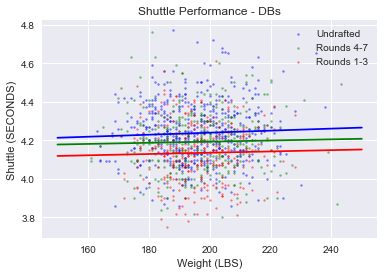

Regression for Undrafted: y=0.000526311435529x + 4.13398149374, R-Squared = 0.00198760438966
Regression for Rounds 4-7: y=0.000297819661813x + 4.13318403278, R-Squared = 0.000687067368613
Regression for Rounds 1-3: y=0.000334697393855x + 4.06833223932, R-Squared = 0.000607127799958


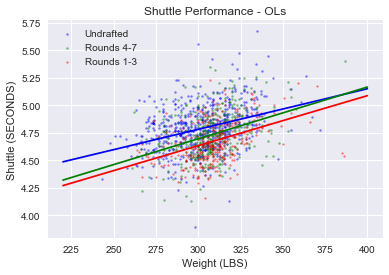

Regression for Undrafted: y=0.00369517310959x + 3.6737305751, R-Squared = 0.118827818818
Regression for Rounds 4-7: y=0.00470417130157x + 3.28540318177, R-Squared = 0.139577663607
Regression for Rounds 1-3: y=0.00454525247286x + 3.27047660505, R-Squared = 0.174671997258


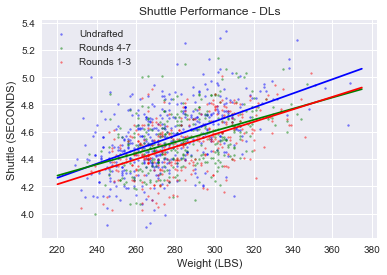

Regression for Undrafted: y=0.00515480566556x + 3.12865263051, R-Squared = 0.280127160837
Regression for Rounds 4-7: y=0.00408549119983x + 3.38013999009, R-Squared = 0.202960101378
Regression for Rounds 1-3: y=0.00457167190581x + 3.20962419122, R-Squared = 0.276494833576


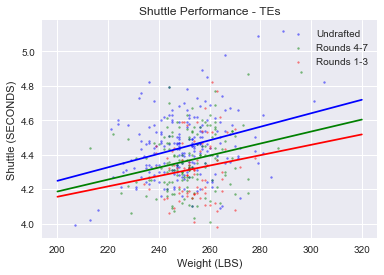

Regression for Undrafted: y=0.00392109769475x + 3.46400666131, R-Squared = 0.0951106698483
Regression for Rounds 4-7: y=0.00348109167168x + 3.48982125059, R-Squared = 0.0563638680889
Regression for Rounds 1-3: y=0.00301540351755x + 3.55252644991, R-Squared = 0.0210991066942


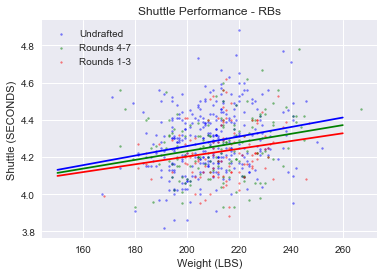

Regression for Undrafted: y=0.00255753155777x + 3.7468976711, R-Squared = 0.0474720281697
Regression for Rounds 4-7: y=0.00233524055414x + 3.76382529684, R-Squared = 0.0562869893422
Regression for Rounds 1-3: y=0.00208339046849x + 3.78542290868, R-Squared = 0.0369083420555


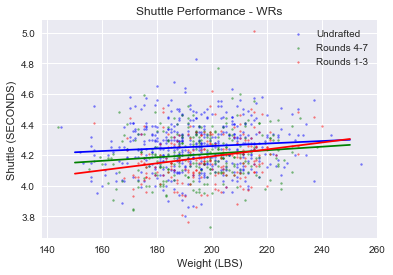

Regression for Undrafted: y=0.000816248615475x + 4.09594696399, R-Squared = 0.00829592908326
Regression for Rounds 4-7: y=0.00115352056826x + 3.97813358141, R-Squared = 0.0161959373365
Regression for Rounds 1-3: y=0.00226470760886x + 3.73906647745, R-Squared = 0.0499536388795


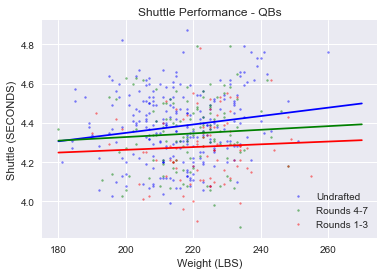

Regression for Undrafted: y=0.00213800301764x + 3.92128664671, R-Squared = 0.0255860767845
Regression for Rounds 4-7: y=0.000922295218625x + 4.14330258222, R-Squared = 0.00386100681162
Regression for Rounds 1-3: y=0.000699758275817x + 4.12281522967, R-Squared = 0.00260700232953


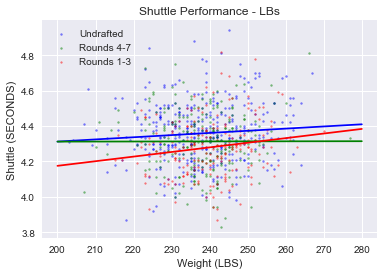

Regression for Undrafted: y=0.00121960789142x + 4.06819180086, R-Squared = 0.00675359098339
Regression for Rounds 4-7: y=2.81055539776e-05x + 4.30633309019, R-Squared = 2.62519290249e-06
Regression for Rounds 1-3: y=0.00260561914672x + 3.6540110107, R-Squared = 0.0250189791837


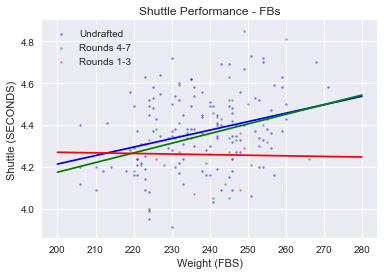

Regression for Undrafted: y=0.00405226966407x + 3.40314798475, R-Squared = 0.0959871706446
Regression for Rounds 4-7: y=0.00461510733739x + 3.25149551426, R-Squared = 0.071963898683
Regression for Rounds 1-3: y=-0.000284974093264x + 4.32699769718, R-Squared = 0.00054952152772


In [61]:
#Scatterplot for DB Group - Shuttle
Shuttle_db_weight_13 = df_DB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_db_weight_13 = Shuttle_db_weight_13[Shuttle_db_weight_13['Rnd'] == '1-3']

Shuttle_db_weight_47 = df_DB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_db_weight_47 = Shuttle_db_weight_47[Shuttle_db_weight_47['Rnd'] == '4-7']

Shuttle_db_weight_Undrafted = df_DB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_db_weight_Undrafted = Shuttle_db_weight_Undrafted[Shuttle_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(Shuttle_db_weight_Undrafted['Weight'], Shuttle_db_weight_Undrafted['Shuttle'], deg=1)
m_db_47, b_db_47 = np.polyfit(Shuttle_db_weight_47['Weight'], Shuttle_db_weight_47['Shuttle'], deg=1)
m_db_13, b_db_13 = np.polyfit(Shuttle_db_weight_13['Weight'], Shuttle_db_weight_13['Shuttle'], deg=1)

Shuttle_db_rsquared_Undrafted = rsquared(Shuttle_db_weight_Undrafted['Weight'], Shuttle_db_weight_Undrafted['Shuttle'])
Shuttle_db_rsquared_47 = rsquared(Shuttle_db_weight_47['Weight'], Shuttle_db_weight_47['Shuttle'])
Shuttle_db_rsquared_13 = rsquared(Shuttle_db_weight_13['Weight'], Shuttle_db_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(Shuttle_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(Shuttle_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(Shuttle_db_rsquared_13))


#Scatterplot for OL Group
Shuttle_OL_weight_13 = df_OL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_OL_weight_13 = Shuttle_OL_weight_13[Shuttle_OL_weight_13['Rnd'] == '1-3']

Shuttle_OL_weight_47 = df_OL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_OL_weight_47 = Shuttle_OL_weight_47[Shuttle_OL_weight_47['Rnd'] == '4-7']

Shuttle_OL_weight_Undrafted = df_OL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_OL_weight_Undrafted = Shuttle_OL_weight_Undrafted[Shuttle_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(Shuttle_OL_weight_Undrafted['Weight'], Shuttle_OL_weight_Undrafted['Shuttle'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(Shuttle_OL_weight_47['Weight'], Shuttle_OL_weight_47['Shuttle'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(Shuttle_OL_weight_13['Weight'], Shuttle_OL_weight_13['Shuttle'], deg=1)

Shuttle_OL_rsquared_Undrafted = rsquared(Shuttle_OL_weight_Undrafted['Weight'], Shuttle_OL_weight_Undrafted['Shuttle'])
Shuttle_OL_rsquared_47 = rsquared(Shuttle_OL_weight_47['Weight'], Shuttle_OL_weight_47['Shuttle'])
Shuttle_OL_rsquared_13 = rsquared(Shuttle_OL_weight_13['Weight'], Shuttle_OL_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(Shuttle_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(Shuttle_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(Shuttle_OL_rsquared_13))


#scatterplot for Shuttle for DL Group
Shuttle_DL_weight_13 = df_DL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_DL_weight_13 = Shuttle_DL_weight_13[Shuttle_DL_weight_13['Rnd'] == '1-3']

Shuttle_DL_weight_47 = df_DL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_DL_weight_47 = Shuttle_DL_weight_47[Shuttle_DL_weight_47['Rnd'] == '4-7']

Shuttle_DL_weight_Undrafted = df_DL[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_DL_weight_Undrafted = Shuttle_DL_weight_Undrafted[Shuttle_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(Shuttle_DL_weight_Undrafted['Weight'], Shuttle_DL_weight_Undrafted['Shuttle'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(Shuttle_DL_weight_47['Weight'], Shuttle_DL_weight_47['Shuttle'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(Shuttle_DL_weight_13['Weight'], Shuttle_DL_weight_13['Shuttle'], deg=1)

Shuttle_DL_rsquared_Undrafted = rsquared(Shuttle_DL_weight_Undrafted['Weight'], Shuttle_DL_weight_Undrafted['Shuttle'])
Shuttle_DL_rsquared_47 = rsquared(Shuttle_DL_weight_47['Weight'], Shuttle_DL_weight_47['Shuttle'])
Shuttle_DL_rsquared_13 = rsquared(Shuttle_DL_weight_13['Weight'], Shuttle_DL_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(Shuttle_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(Shuttle_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(Shuttle_DL_rsquared_13))

#scatterplot for Shuttle for TE Group
Shuttle_TE_weight_13 = df_TE[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_TE_weight_13 = Shuttle_TE_weight_13[Shuttle_TE_weight_13['Rnd'] == '1-3']

Shuttle_TE_weight_47 = df_TE[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_TE_weight_47 = Shuttle_TE_weight_47[Shuttle_TE_weight_47['Rnd'] == '4-7']

Shuttle_TE_weight_Undrafted = df_TE[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_TE_weight_Undrafted = Shuttle_TE_weight_Undrafted[Shuttle_TE_weight_Undrafted['Rnd'] == 'Undrafted']
Shuttle_TE_weight_Undrafted = Shuttle_TE_weight_Undrafted[Shuttle_TE_weight_Undrafted['Weight'] > 180]
Shuttle_TE_weight_Undrafted = Shuttle_TE_weight_Undrafted[Shuttle_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([200,320])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (Shuttle_TE_weight_Undrafted['Weight'], Shuttle_TE_weight_Undrafted['Shuttle'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(Shuttle_TE_weight_47['Weight'], Shuttle_TE_weight_47['Shuttle'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (Shuttle_TE_weight_13['Weight'], Shuttle_TE_weight_13['Shuttle'], deg=1)

Shuttle_TE_rsquared_Undrafted = rsquared(Shuttle_TE_weight_Undrafted['Weight'], Shuttle_TE_weight_Undrafted['Shuttle'])
Shuttle_TE_rsquared_47 = rsquared(Shuttle_TE_weight_47['Weight'], Shuttle_TE_weight_47['Shuttle'])
Shuttle_TE_rsquared_13 = rsquared(Shuttle_TE_weight_13['Weight'], Shuttle_TE_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(Shuttle_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(Shuttle_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(Shuttle_TE_rsquared_13))


#scatterplot for Shuttle for RB Group
Shuttle_RB_weight_13 = df_RB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_RB_weight_13 = Shuttle_RB_weight_13[Shuttle_RB_weight_13['Rnd'] == '1-3']

Shuttle_RB_weight_47 = df_RB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_RB_weight_47 = Shuttle_RB_weight_47[Shuttle_RB_weight_47['Rnd'] == '4-7']

Shuttle_RB_weight_Undrafted = df_RB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_RB_weight_Undrafted = Shuttle_RB_weight_Undrafted[Shuttle_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,260])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (Shuttle_RB_weight_Undrafted ['Weight'], Shuttle_RB_weight_Undrafted ['Shuttle'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(Shuttle_RB_weight_47['Weight'], Shuttle_RB_weight_47['Shuttle'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (Shuttle_RB_weight_13['Weight'], Shuttle_RB_weight_13['Shuttle'], deg=1)

Shuttle_RB_rsquared_Undrafted = rsquared(Shuttle_RB_weight_Undrafted['Weight'], Shuttle_RB_weight_Undrafted['Shuttle'])
Shuttle_RB_rsquared_47 = rsquared(Shuttle_RB_weight_47['Weight'], Shuttle_RB_weight_47['Shuttle'])
Shuttle_RB_rsquared_13 = rsquared(Shuttle_RB_weight_13['Weight'], Shuttle_RB_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(Shuttle_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(Shuttle_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(Shuttle_RB_rsquared_13))


#scatterplot for Shuttle for WR Group
Shuttle_WR_weight_13 = df_WR[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_WR_weight_13 = Shuttle_WR_weight_13[Shuttle_WR_weight_13['Rnd'] == '1-3']

Shuttle_WR_weight_47 = df_WR[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_WR_weight_47 = Shuttle_WR_weight_47[Shuttle_WR_weight_47['Rnd'] == '4-7']

Shuttle_WR_weight_Undrafted = df_WR[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_WR_weight_Undrafted = Shuttle_WR_weight_Undrafted[Shuttle_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (Shuttle_WR_weight_Undrafted ['Weight'], Shuttle_WR_weight_Undrafted ['Shuttle'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(Shuttle_WR_weight_47['Weight'], Shuttle_WR_weight_47['Shuttle'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (Shuttle_WR_weight_13['Weight'], Shuttle_WR_weight_13['Shuttle'], deg=1)

Shuttle_WR_rsquared_Undrafted = rsquared(Shuttle_WR_weight_Undrafted['Weight'], Shuttle_WR_weight_Undrafted['Shuttle'])
Shuttle_WR_rsquared_47 = rsquared(Shuttle_WR_weight_47['Weight'], Shuttle_WR_weight_47['Shuttle'])
Shuttle_WR_rsquared_13 = rsquared(Shuttle_WR_weight_13['Weight'], Shuttle_WR_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(Shuttle_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(Shuttle_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(Shuttle_WR_rsquared_13))


#scatterplot for Shuttle for QB Group
Shuttle_QB_weight_13 = df_QB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_QB_weight_13 = Shuttle_QB_weight_13[Shuttle_QB_weight_13['Rnd'] == '1-3']

Shuttle_QB_weight_47 = df_QB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_QB_weight_47 = Shuttle_QB_weight_47[Shuttle_QB_weight_47['Rnd'] == '4-7']

Shuttle_QB_weight_Undrafted = df_QB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_QB_weight_Undrafted = Shuttle_QB_weight_Undrafted[Shuttle_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (Shuttle_QB_weight_Undrafted ['Weight'], Shuttle_QB_weight_Undrafted ['Shuttle'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(Shuttle_QB_weight_47['Weight'], Shuttle_QB_weight_47['Shuttle'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (Shuttle_QB_weight_13['Weight'], Shuttle_QB_weight_13['Shuttle'], deg=1)

Shuttle_QB_rsquared_Undrafted = rsquared(Shuttle_QB_weight_Undrafted['Weight'], Shuttle_QB_weight_Undrafted['Shuttle'])
Shuttle_QB_rsquared_47 = rsquared(Shuttle_QB_weight_47['Weight'], Shuttle_QB_weight_47['Shuttle'])
Shuttle_QB_rsquared_13 = rsquared(Shuttle_QB_weight_13['Weight'], Shuttle_QB_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(Shuttle_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(Shuttle_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(Shuttle_QB_rsquared_13))

#scatterplot for Shuttle for LB Group
Shuttle_LB_weight_13 = df_LB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_LB_weight_13 = Shuttle_LB_weight_13[Shuttle_LB_weight_13['Rnd'] == '1-3']

Shuttle_LB_weight_47 = df_LB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_LB_weight_47 = Shuttle_LB_weight_47[Shuttle_LB_weight_47['Rnd'] == '4-7']

Shuttle_LB_weight_Undrafted = df_LB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_LB_weight_Undrafted = Shuttle_LB_weight_Undrafted[Shuttle_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (Shuttle_LB_weight_Undrafted ['Weight'], Shuttle_LB_weight_Undrafted ['Shuttle'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(Shuttle_LB_weight_47['Weight'], Shuttle_LB_weight_47['Shuttle'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (Shuttle_LB_weight_13['Weight'], Shuttle_LB_weight_13['Shuttle'], deg=1)

Shuttle_LB_rsquared_Undrafted = rsquared(Shuttle_LB_weight_Undrafted['Weight'], Shuttle_LB_weight_Undrafted['Shuttle'])
Shuttle_LB_rsquared_47 = rsquared(Shuttle_LB_weight_47['Weight'], Shuttle_LB_weight_47['Shuttle'])
Shuttle_LB_rsquared_13 = rsquared(Shuttle_LB_weight_13['Weight'], Shuttle_LB_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(Shuttle_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(Shuttle_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(Shuttle_LB_rsquared_13))

#scatterplot for Shuttle for FB Group
Shuttle_FB_weight_13 = df_FB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_FB_weight_13 = Shuttle_FB_weight_13[Shuttle_FB_weight_13['Rnd'] == '1-3']

Shuttle_FB_weight_47 = df_FB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_FB_weight_47 = Shuttle_FB_weight_47[Shuttle_FB_weight_47['Rnd'] == '4-7']

Shuttle_FB_weight_Undrafted = df_FB[['Weight', 'Shuttle', 'Rnd']].dropna()
Shuttle_FB_weight_Undrafted = Shuttle_FB_weight_Undrafted[Shuttle_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (Shuttle_FB_weight_Undrafted ['Weight'], Shuttle_FB_weight_Undrafted ['Shuttle'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(Shuttle_FB_weight_47['Weight'], Shuttle_FB_weight_47['Shuttle'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (Shuttle_FB_weight_13['Weight'], Shuttle_FB_weight_13['Shuttle'], deg=1)

Shuttle_FB_rsquared_Undrafted = rsquared(Shuttle_FB_weight_Undrafted['Weight'], Shuttle_FB_weight_Undrafted['Shuttle'])
Shuttle_FB_rsquared_47 = rsquared(Shuttle_FB_weight_47['Weight'], Shuttle_FB_weight_47['Shuttle'])
Shuttle_FB_rsquared_13 = rsquared(Shuttle_FB_weight_13['Weight'], Shuttle_FB_weight_13['Shuttle'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatFBrplots in different colors for different round groups
blue = plt.scatter('Weight', 'Shuttle', data = Shuttle_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Shuttle', data = Shuttle_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Shuttle', data = Shuttle_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (FBS)')
_ = plt.ylabel('Shuttle (SECONDS)')
_ = plt.title('Shuttle Performance - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(Shuttle_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(Shuttle_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(Shuttle_FB_rsquared_13))


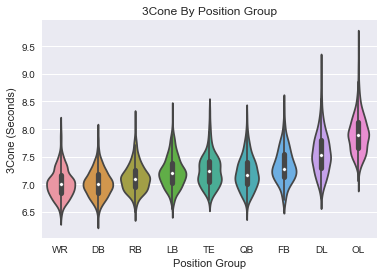

In [57]:
#Create a violinplot for 3Cone, grouped by position
Cone_df_pos = df_joined[['Pos', '3Cone']].dropna()

sns.set()
_ = sns.violinplot('Pos', '3Cone', data = Cone_df_pos, order = ['WR', 'DB', 'RB', 'LB', 'TE', 'QB', 'FB', 'DL', 'OL'])
_ = plt.xlabel('Position Group')
_ = plt.ylabel('3Cone (Seconds)')
_ = plt.title('3Cone By Position Group')
_ = plt.show()

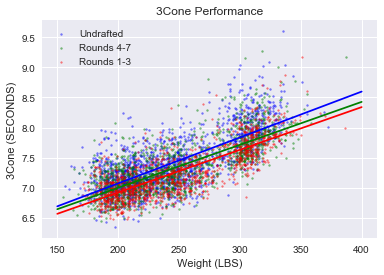

Regression for Undrafted: y=0.00763966305157x + 5.54251956634, R-Squared = 0.531317360952
Regression for Rounds 4-7: y=0.0071446762807x + 5.56915282945, R-Squared = 0.572192936004
Regression for Rounds 1-3: y=0.00710389494165x + 5.49842531016, R-Squared = 0.612567208368


In [58]:
#Create a scatterplot of 3Cone against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

Cone_13 = df_joined[['Weight', '3Cone', 'Rnd']].dropna()
Cone_13 = Cone_13[Cone_13['Rnd'] == '1-3']

Cone_47 = df_joined[['Weight', '3Cone', 'Rnd']].dropna()
Cone_47 = Cone_47[Cone_47['Rnd'] == '4-7']

Cone_Undrafted = df_joined[['Weight', '3Cone', 'Rnd']].dropna()
Cone_Undrafted = Cone_Undrafted[Cone_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_Cone_Undrafted, b_Cone_Undrafted = np.polyfit(Cone_Undrafted['Weight'], Cone_Undrafted['3Cone'], deg=1)
m_Cone_47, b_Cone_47 = np.polyfit(Cone_47['Weight'], Cone_47['3Cone'], deg=1)
m_Cone_13, b_Cone_13 = np.polyfit(Cone_13['Weight'], Cone_13['3Cone'], deg=1)


#calculate R squared of each group
Cone_rsquared_Undrafted = rsquared(Cone_Undrafted['Weight'], Cone_Undrafted['3Cone'])
Cone_rsquared_47 = rsquared(Cone_47['Weight'], Cone_47['3Cone'])
Cone_rsquared_13 = rsquared(Cone_13['Weight'], Cone_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_Cone_Undrafted*x + b_Cone_Undrafted, color = 'blue')
_ = plt.plot(x, m_Cone_47*x + b_Cone_47, color = 'green')
_ = plt.plot(x, m_Cone_13*x + b_Cone_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('3Cone (SECONDS)')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])
plt.title('3Cone Performance')
plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_Cone_Undrafted) + 'x + ' + str(b_Cone_Undrafted)  + ', R-Squared = ' + str(Cone_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_Cone_47) + 'x + ' + str(b_Cone_47) + ', R-Squared = ' + str(Cone_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_Cone_13) + 'x + ' + str(b_Cone_13) + ', R-Squared = ' + str(Cone_rsquared_13))

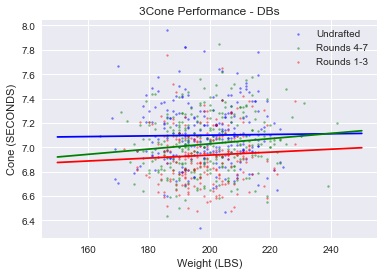

Regression for Undrafted: y=0.000289807608276x + 7.04172495481, R-Squared = 0.000204692346975
Regression for Rounds 4-7: y=0.00215312714742x + 6.59768299167, R-Squared = 0.0131370079856
Regression for Rounds 1-3: y=0.00121274268723x + 6.69345030131, R-Squared = 0.00321783596204


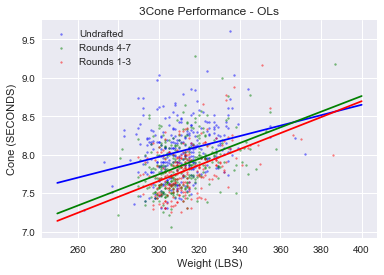

Regression for Undrafted: y=0.00677068817586x + 5.93992488316, R-Squared = 0.0731274311688
Regression for Rounds 4-7: y=0.0101801175816x + 4.68983066519, R-Squared = 0.170278388834
Regression for Rounds 1-3: y=0.0103745878172x + 4.54482570818, R-Squared = 0.213342099046


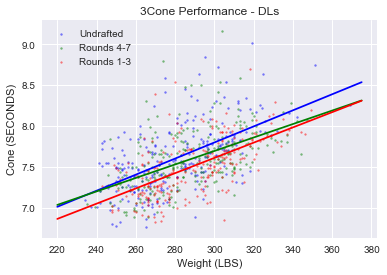

Regression for Undrafted: y=0.0098390977135x + 4.8451870337, R-Squared = 0.333434860165
Regression for Rounds 4-7: y=0.00824745686015x + 5.21857356691, R-Squared = 0.267828043227
Regression for Rounds 1-3: y=0.00933396738897x + 4.80791135031, R-Squared = 0.372429200889


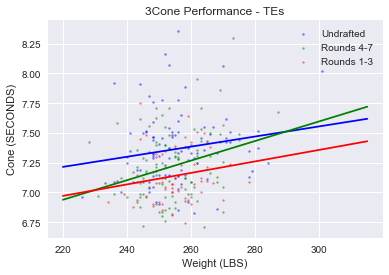

Regression for Undrafted: y=0.00425512597093x + 6.27884715978, R-Squared = 0.0296733251811
Regression for Rounds 4-7: y=0.00823435296979x + 5.12710374601, R-Squared = 0.0827228346238
Regression for Rounds 1-3: y=0.00483487589398x + 5.90741480858, R-Squared = 0.033512866379


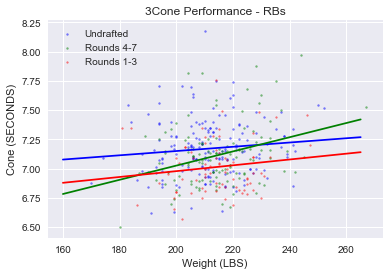

Regression for Undrafted: y=0.00182360395001x + 6.78481777268, R-Squared = 0.0112261182615
Regression for Rounds 4-7: y=0.00607405035227x + 5.81025200769, R-Squared = 0.0988710304704
Regression for Rounds 1-3: y=0.00249413260317x + 6.47872650819, R-Squared = 0.0183798931729


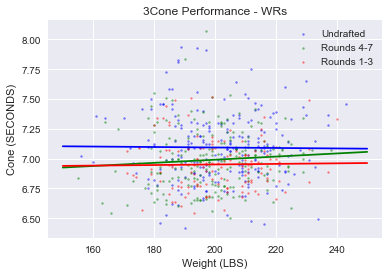

Regression for Undrafted: y=-0.000199956962214x + 7.13344499962, R-Squared = 0.000118759448625
Regression for Rounds 4-7: y=0.00131336959114x + 6.72821268779, R-Squared = 0.00606812488026
Regression for Rounds 1-3: y=0.000238586032452x + 6.90331891937, R-Squared = 0.000266365262386


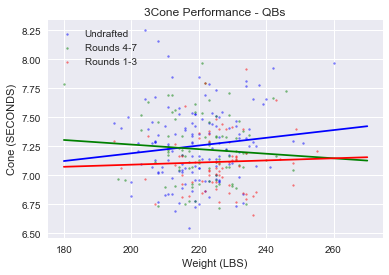

Regression for Undrafted: y=0.00333416523692x + 6.52407887409, R-Squared = 0.0140851747057
Regression for Rounds 4-7: y=-0.00197424614309x + 7.66111044153, R-Squared = 0.00605284203996
Regression for Rounds 1-3: y=0.000915651789245x + 6.90980051543, R-Squared = 0.00156653617435


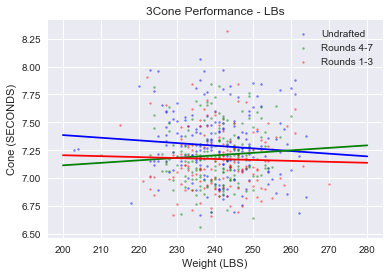

Regression for Undrafted: y=-0.0023865806378x + 7.86305304246, R-Squared = 0.00733546653468
Regression for Rounds 4-7: y=0.00224030059251x + 6.6663248326, R-Squared = 0.00482279809372
Regression for Rounds 1-3: y=-0.000848694556074x + 7.37477536422, R-Squared = 0.000828330455371


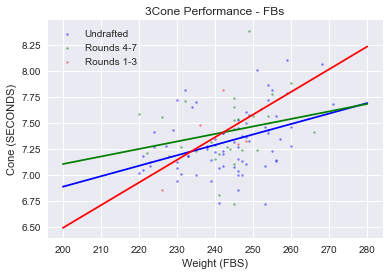

Regression for Undrafted: y=0.0100421130382x + 4.87668751189, R-Squared = 0.150795357502
Regression for Rounds 4-7: y=0.00722042524854x + 5.65897469438, R-Squared = 0.0544552952669
Regression for Rounds 1-3: y=0.0217766497462x + 2.13431472081, R-Squared = 0.310191175931


In [74]:
#Scatterplot for DB Group - Cone
Cone_db_weight_13 = df_DB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_db_weight_13 = Cone_db_weight_13[Cone_db_weight_13['Rnd'] == '1-3']

Cone_db_weight_47 = df_DB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_db_weight_47 = Cone_db_weight_47[Cone_db_weight_47['Rnd'] == '4-7']

Cone_db_weight_Undrafted = df_DB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_db_weight_Undrafted = Cone_db_weight_Undrafted[Cone_db_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_db_Undrafted, b_db_Undrafted = np.polyfit(Cone_db_weight_Undrafted['Weight'], Cone_db_weight_Undrafted['3Cone'], deg=1)
m_db_47, b_db_47 = np.polyfit(Cone_db_weight_47['Weight'], Cone_db_weight_47['3Cone'], deg=1)
m_db_13, b_db_13 = np.polyfit(Cone_db_weight_13['Weight'], Cone_db_weight_13['3Cone'], deg=1)

Cone_db_rsquared_Undrafted = rsquared(Cone_db_weight_Undrafted['Weight'], Cone_db_weight_Undrafted['3Cone'])
Cone_db_rsquared_47 = rsquared(Cone_db_weight_47['Weight'], Cone_db_weight_47['3Cone'])
Cone_db_rsquared_13 = rsquared(Cone_db_weight_13['Weight'], Cone_db_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_db_Undrafted*x + b_db_Undrafted, color = 'blue')
_ = plt.plot(x, m_db_47*x + b_db_47, color = 'green')
_ = plt.plot(x, m_db_13*x + b_db_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_db_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_db_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_db_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - DBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_db_Undrafted) + 'x + ' + str(b_db_Undrafted) + ', R-Squared = ' + str(Cone_db_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_db_47) + 'x + ' + str(b_db_47) + ', R-Squared = ' + str(Cone_db_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_db_13) + 'x + ' + str(b_db_13) + ', R-Squared = ' + str(Cone_db_rsquared_13))


#Scatterplot for OL Group
Cone_OL_weight_13 = df_OL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_OL_weight_13 = Cone_OL_weight_13[Cone_OL_weight_13['Rnd'] == '1-3']

Cone_OL_weight_47 = df_OL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_OL_weight_47 = Cone_OL_weight_47[Cone_OL_weight_47['Rnd'] == '4-7']

Cone_OL_weight_Undrafted = df_OL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_OL_weight_Undrafted = Cone_OL_weight_Undrafted[Cone_OL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([250,400])
m_OL_Undrafted, b_OL_Undrafted = np.polyfit(Cone_OL_weight_Undrafted['Weight'], Cone_OL_weight_Undrafted['3Cone'], deg=1)
m_OL_47, b_OL_47 = np.polyfit(Cone_OL_weight_47['Weight'], Cone_OL_weight_47['3Cone'], deg=1)
m_OL_13, b_OL_13 = np.polyfit(Cone_OL_weight_13['Weight'], Cone_OL_weight_13['3Cone'], deg=1)

Cone_OL_rsquared_Undrafted = rsquared(Cone_OL_weight_Undrafted['Weight'], Cone_OL_weight_Undrafted['3Cone'])
Cone_OL_rsquared_47 = rsquared(Cone_OL_weight_47['Weight'], Cone_OL_weight_47['3Cone'])
Cone_OL_rsquared_13 = rsquared(Cone_OL_weight_13['Weight'], Cone_OL_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_OL_Undrafted*x + b_OL_Undrafted, color = 'blue')
_ = plt.plot(x, m_OL_47*x + b_OL_47, color = 'green')
_ = plt.plot(x, m_OL_13*x + b_OL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_OL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_OL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_OL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - OLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_OL_Undrafted) + 'x + ' + str(b_OL_Undrafted) + ', R-Squared = ' + str(Cone_OL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_OL_47) + 'x + ' + str(b_OL_47) + ', R-Squared = ' + str(Cone_OL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_OL_13) + 'x + ' + str(b_OL_13) + ', R-Squared = ' + str(Cone_OL_rsquared_13))


#scatterplot for Cone for DL Group
Cone_DL_weight_13 = df_DL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_DL_weight_13 = Cone_DL_weight_13[Cone_DL_weight_13['Rnd'] == '1-3']

Cone_DL_weight_47 = df_DL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_DL_weight_47 = Cone_DL_weight_47[Cone_DL_weight_47['Rnd'] == '4-7']

Cone_DL_weight_Undrafted = df_DL[['Weight', '3Cone', 'Rnd']].dropna()
Cone_DL_weight_Undrafted = Cone_DL_weight_Undrafted[Cone_DL_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([220,375])
m_DL_Undrafted, b_DL_Undrafted = np.polyfit(Cone_DL_weight_Undrafted['Weight'], Cone_DL_weight_Undrafted['3Cone'], deg=1)
m_DL_47, b_DL_47 = np.polyfit(Cone_DL_weight_47['Weight'], Cone_DL_weight_47['3Cone'], deg=1)
m_DL_13, b_DL_13 = np.polyfit(Cone_DL_weight_13['Weight'], Cone_DL_weight_13['3Cone'], deg=1)

Cone_DL_rsquared_Undrafted = rsquared(Cone_DL_weight_Undrafted['Weight'], Cone_DL_weight_Undrafted['3Cone'])
Cone_DL_rsquared_47 = rsquared(Cone_DL_weight_47['Weight'], Cone_DL_weight_47['3Cone'])
Cone_DL_rsquared_13 = rsquared(Cone_DL_weight_13['Weight'], Cone_DL_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_DL_Undrafted*x + b_DL_Undrafted, color = 'blue')
_ = plt.plot(x, m_DL_47*x + b_DL_47, color = 'green')
_ = plt.plot(x, m_DL_13*x + b_DL_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_DL_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_DL_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_DL_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - DLs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_DL_Undrafted) + 'x + ' + str(b_DL_Undrafted) + ', R-Squared = ' + str(Cone_DL_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_DL_47) + 'x + ' + str(b_DL_47) + ', R-Squared = ' + str(Cone_DL_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_DL_13) + 'x + ' + str(b_DL_13) + ', R-Squared = ' + str(Cone_DL_rsquared_13))

#scatterplot for Cone for TE Group
Cone_TE_weight_13 = df_TE[['Weight', '3Cone', 'Rnd']].dropna()
Cone_TE_weight_13 = Cone_TE_weight_13[Cone_TE_weight_13['Rnd'] == '1-3']

Cone_TE_weight_47 = df_TE[['Weight', '3Cone', 'Rnd']].dropna()
Cone_TE_weight_47 = Cone_TE_weight_47[Cone_TE_weight_47['Rnd'] == '4-7']

Cone_TE_weight_Undrafted = df_TE[['Weight', '3Cone', 'Rnd']].dropna()
Cone_TE_weight_Undrafted = Cone_TE_weight_Undrafted[Cone_TE_weight_Undrafted['Rnd'] == 'Undrafted']
Cone_TE_weight_Undrafted = Cone_TE_weight_Undrafted[Cone_TE_weight_Undrafted['Weight'] > 180]
Cone_TE_weight_Undrafted = Cone_TE_weight_Undrafted[Cone_TE_weight_Undrafted['Weight'] < 320]


#calculate regression lines for all 3 groups
x = np.array([220,315])
m_TE_Undrafted, b_TE_Undrafted = np. polyfit (Cone_TE_weight_Undrafted['Weight'], Cone_TE_weight_Undrafted['3Cone'], deg=1)
m_TE_47, b_TE_47 = np.polyfit(Cone_TE_weight_47['Weight'], Cone_TE_weight_47['3Cone'], deg=1)
m_TE_13, b_TE_13 = np. polyfit (Cone_TE_weight_13['Weight'], Cone_TE_weight_13['3Cone'], deg=1)

Cone_TE_rsquared_Undrafted = rsquared(Cone_TE_weight_Undrafted['Weight'], Cone_TE_weight_Undrafted['3Cone'])
Cone_TE_rsquared_47 = rsquared(Cone_TE_weight_47['Weight'], Cone_TE_weight_47['3Cone'])
Cone_TE_rsquared_13 = rsquared(Cone_TE_weight_13['Weight'], Cone_TE_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_TE_Undrafted*x + b_TE_Undrafted, color = 'blue')
_ = plt.plot(x, m_TE_47*x + b_TE_47, color = 'green')
_ = plt.plot(x, m_TE_13*x + b_TE_13, color = 'red')


#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_TE_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_TE_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_TE_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - TEs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_TE_Undrafted) + 'x + ' + str(b_TE_Undrafted) + ', R-Squared = ' + str(Cone_TE_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_TE_47) + 'x + ' + str(b_TE_47) + ', R-Squared = ' + str(Cone_TE_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_TE_13) + 'x + ' + str(b_TE_13) + ', R-Squared = ' + str(Cone_TE_rsquared_13))


#scatterplot for Cone for RB Group
Cone_RB_weight_13 = df_RB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_RB_weight_13 = Cone_RB_weight_13[Cone_RB_weight_13['Rnd'] == '1-3']

Cone_RB_weight_47 = df_RB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_RB_weight_47 = Cone_RB_weight_47[Cone_RB_weight_47['Rnd'] == '4-7']

Cone_RB_weight_Undrafted = df_RB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_RB_weight_Undrafted = Cone_RB_weight_Undrafted[Cone_RB_weight_Undrafted ['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([160,265])
m_RB_Undrafted, b_RB_Undrafted = np. polyfit (Cone_RB_weight_Undrafted ['Weight'], Cone_RB_weight_Undrafted ['3Cone'], deg=1)
m_RB_47, b_RB_47 = np.polyfit(Cone_RB_weight_47['Weight'], Cone_RB_weight_47['3Cone'], deg=1)
m_RB_13, b_RB_13 = np. polyfit (Cone_RB_weight_13['Weight'], Cone_RB_weight_13['3Cone'], deg=1)

Cone_RB_rsquared_Undrafted = rsquared(Cone_RB_weight_Undrafted['Weight'], Cone_RB_weight_Undrafted['3Cone'])
Cone_RB_rsquared_47 = rsquared(Cone_RB_weight_47['Weight'], Cone_RB_weight_47['3Cone'])
Cone_RB_rsquared_13 = rsquared(Cone_RB_weight_13['Weight'], Cone_RB_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_RB_Undrafted*x + b_RB_Undrafted, color = 'blue')
_ = plt.plot(x, m_RB_47*x + b_RB_47, color = 'green')
_ = plt.plot(x, m_RB_13*x + b_RB_13, color = 'red')


#scatRBrplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_RB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_RB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_RB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - RBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_RB_Undrafted) + 'x + ' + str(b_RB_Undrafted) + ', R-Squared = ' + str(Cone_RB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_RB_47) + 'x + ' + str(b_RB_47) + ', R-Squared = ' + str(Cone_RB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_RB_13) + 'x + ' + str(b_RB_13) + ', R-Squared = ' + str(Cone_RB_rsquared_13))


#scatterplot for Cone for WR Group
Cone_WR_weight_13 = df_WR[['Weight', '3Cone', 'Rnd']].dropna()
Cone_WR_weight_13 = Cone_WR_weight_13[Cone_WR_weight_13['Rnd'] == '1-3']

Cone_WR_weight_47 = df_WR[['Weight', '3Cone', 'Rnd']].dropna()
Cone_WR_weight_47 = Cone_WR_weight_47[Cone_WR_weight_47['Rnd'] == '4-7']

Cone_WR_weight_Undrafted = df_WR[['Weight', '3Cone', 'Rnd']].dropna()
Cone_WR_weight_Undrafted = Cone_WR_weight_Undrafted[Cone_WR_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,250])
m_WR_Undrafted, b_WR_Undrafted = np. polyfit (Cone_WR_weight_Undrafted ['Weight'], Cone_WR_weight_Undrafted ['3Cone'], deg=1)
m_WR_47, b_WR_47 = np.polyfit(Cone_WR_weight_47['Weight'], Cone_WR_weight_47['3Cone'], deg=1)
m_WR_13, b_WR_13 = np. polyfit (Cone_WR_weight_13['Weight'], Cone_WR_weight_13['3Cone'], deg=1)

Cone_WR_rsquared_Undrafted = rsquared(Cone_WR_weight_Undrafted['Weight'], Cone_WR_weight_Undrafted['3Cone'])
Cone_WR_rsquared_47 = rsquared(Cone_WR_weight_47['Weight'], Cone_WR_weight_47['3Cone'])
Cone_WR_rsquared_13 = rsquared(Cone_WR_weight_13['Weight'], Cone_WR_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_WR_Undrafted*x + b_WR_Undrafted, color = 'blue')
_ = plt.plot(x, m_WR_47*x + b_WR_47, color = 'green')
_ = plt.plot(x, m_WR_13*x + b_WR_13, color = 'red')


#scatWRrplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_WR_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_WR_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_WR_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - WRs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_WR_Undrafted) + 'x + ' + str(b_WR_Undrafted) + ', R-Squared = ' + str(Cone_WR_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_WR_47) + 'x + ' + str(b_WR_47) + ', R-Squared = ' + str(Cone_WR_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_WR_13) + 'x + ' + str(b_WR_13) + ', R-Squared = ' + str(Cone_WR_rsquared_13))


#scatterplot for Cone for QB Group
Cone_QB_weight_13 = df_QB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_QB_weight_13 = Cone_QB_weight_13[Cone_QB_weight_13['Rnd'] == '1-3']

Cone_QB_weight_47 = df_QB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_QB_weight_47 = Cone_QB_weight_47[Cone_QB_weight_47['Rnd'] == '4-7']

Cone_QB_weight_Undrafted = df_QB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_QB_weight_Undrafted = Cone_QB_weight_Undrafted[Cone_QB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([180,270])
m_QB_Undrafted, b_QB_Undrafted = np. polyfit (Cone_QB_weight_Undrafted ['Weight'], Cone_QB_weight_Undrafted ['3Cone'], deg=1)
m_QB_47, b_QB_47 = np.polyfit(Cone_QB_weight_47['Weight'], Cone_QB_weight_47['3Cone'], deg=1)
m_QB_13, b_QB_13 = np. polyfit (Cone_QB_weight_13['Weight'], Cone_QB_weight_13['3Cone'], deg=1)

Cone_QB_rsquared_Undrafted = rsquared(Cone_QB_weight_Undrafted['Weight'], Cone_QB_weight_Undrafted['3Cone'])
Cone_QB_rsquared_47 = rsquared(Cone_QB_weight_47['Weight'], Cone_QB_weight_47['3Cone'])
Cone_QB_rsquared_13 = rsquared(Cone_QB_weight_13['Weight'], Cone_QB_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_QB_Undrafted*x + b_QB_Undrafted, color = 'blue')
_ = plt.plot(x, m_QB_47*x + b_QB_47, color = 'green')
_ = plt.plot(x, m_QB_13*x + b_QB_13, color = 'red')


#scatQBrplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_QB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_QB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_QB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - QBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_QB_Undrafted) + 'x + ' + str(b_QB_Undrafted) + ', R-Squared = ' + str(Cone_QB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_QB_47) + 'x + ' + str(b_QB_47) + ', R-Squared = ' + str(Cone_QB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_QB_13) + 'x + ' + str(b_QB_13) + ', R-Squared = ' + str(Cone_QB_rsquared_13))

#scatterplot for Cone for LB Group
Cone_LB_weight_13 = df_LB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_LB_weight_13 = Cone_LB_weight_13[Cone_LB_weight_13['Rnd'] == '1-3']

Cone_LB_weight_47 = df_LB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_LB_weight_47 = Cone_LB_weight_47[Cone_LB_weight_47['Rnd'] == '4-7']

Cone_LB_weight_Undrafted = df_LB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_LB_weight_Undrafted = Cone_LB_weight_Undrafted[Cone_LB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_LB_Undrafted, b_LB_Undrafted = np. polyfit (Cone_LB_weight_Undrafted ['Weight'], Cone_LB_weight_Undrafted ['3Cone'], deg=1)
m_LB_47, b_LB_47 = np.polyfit(Cone_LB_weight_47['Weight'], Cone_LB_weight_47['3Cone'], deg=1)
m_LB_13, b_LB_13 = np. polyfit (Cone_LB_weight_13['Weight'], Cone_LB_weight_13['3Cone'], deg=1)

Cone_LB_rsquared_Undrafted = rsquared(Cone_LB_weight_Undrafted['Weight'], Cone_LB_weight_Undrafted['3Cone'])
Cone_LB_rsquared_47 = rsquared(Cone_LB_weight_47['Weight'], Cone_LB_weight_47['3Cone'])
Cone_LB_rsquared_13 = rsquared(Cone_LB_weight_13['Weight'], Cone_LB_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_LB_Undrafted*x + b_LB_Undrafted, color = 'blue')
_ = plt.plot(x, m_LB_47*x + b_LB_47, color = 'green')
_ = plt.plot(x, m_LB_13*x + b_LB_13, color = 'red')


#scatLBrplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_LB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_LB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_LB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (LBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - LBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_LB_Undrafted) + 'x + ' + str(b_LB_Undrafted) + ', R-Squared = ' + str(Cone_LB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_LB_47) + 'x + ' + str(b_LB_47) + ', R-Squared = ' + str(Cone_LB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_LB_13) + 'x + ' + str(b_LB_13) + ', R-Squared = ' + str(Cone_LB_rsquared_13))

#scatterplot for Cone for FB Group
Cone_FB_weight_13 = df_FB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_FB_weight_13 = Cone_FB_weight_13[Cone_FB_weight_13['Rnd'] == '1-3']

Cone_FB_weight_47 = df_FB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_FB_weight_47 = Cone_FB_weight_47[Cone_FB_weight_47['Rnd'] == '4-7']

Cone_FB_weight_Undrafted = df_FB[['Weight', '3Cone', 'Rnd']].dropna()
Cone_FB_weight_Undrafted = Cone_FB_weight_Undrafted[Cone_FB_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([200,280])
m_FB_Undrafted, b_FB_Undrafted = np. polyfit (Cone_FB_weight_Undrafted ['Weight'], Cone_FB_weight_Undrafted ['3Cone'], deg=1)
m_FB_47, b_FB_47 = np.polyfit(Cone_FB_weight_47['Weight'], Cone_FB_weight_47['3Cone'], deg=1)
m_FB_13, b_FB_13 = np. polyfit (Cone_FB_weight_13['Weight'], Cone_FB_weight_13['3Cone'], deg=1)

Cone_FB_rsquared_Undrafted = rsquared(Cone_FB_weight_Undrafted['Weight'], Cone_FB_weight_Undrafted['3Cone'])
Cone_FB_rsquared_47 = rsquared(Cone_FB_weight_47['Weight'], Cone_FB_weight_47['3Cone'])
Cone_FB_rsquared_13 = rsquared(Cone_FB_weight_13['Weight'], Cone_FB_weight_13['3Cone'])


#plotting regression lines
_ = plt.plot(x, m_FB_Undrafted*x + b_FB_Undrafted, color = 'blue')
_ = plt.plot(x, m_FB_47*x + b_FB_47, color = 'green')
_ = plt.plot(x, m_FB_13*x + b_FB_13, color = 'red')


#scatFBrplots in different colors for different round groups
blue = plt.scatter('Weight', '3Cone', data = Cone_FB_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '3Cone', data = Cone_FB_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '3Cone', data = Cone_FB_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight (FBS)')
_ = plt.ylabel('Cone (SECONDS)')
_ = plt.title('3Cone Performance - FBs')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y=' + str(m_FB_Undrafted) + 'x + ' + str(b_FB_Undrafted) + ', R-Squared = ' + str(Cone_FB_rsquared_Undrafted))
print('Regression for Rounds 4-7: y=' + str(m_FB_47) + 'x + ' + str(b_FB_47) + ', R-Squared = ' + str(Cone_FB_rsquared_47))
print('Regression for Rounds 1-3: y=' + str(m_FB_13) + 'x + ' + str(b_FB_13) + ', R-Squared = ' + str(Cone_FB_rsquared_13))

